In [1]:
# general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

import os, sys, time, glob
import json
import copy
import scipy
import warnings
from tqdm import tqdm

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

# bilby
import bilby
from bilby.core.prior import Uniform, DeltaFunction
from bilby.core.likelihood import GaussianLikelihood

# nflows
from nflows.nn.nets.resnet import ResidualNet
from nflows import transforms, distributions, flows
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation
import nflows.utils as torchutils

# extras
from IPython.display import clear_output
from time import time
from time import sleep
import corner
import torchvision
import torchvision.transforms as transforms
from os.path import exists

# importing resnet from ML4GW
from resnet import ResNet

/home/oppenheimer/miniconda3/envs/ML/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-06-10 15:19:27.234414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 15:19:27.600704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 15:19:27.721893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-

ModuleNotFoundError: No module named 'resnet'

In [ ]:
# checking gpu status, ensures tensors are stored on the same device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [4]:
# json specific parameters, adjust this cell with commands when generating light curves -- MANDATORY

bands = ['ztfg', 'ztfr', 'ztfi']
detection_limit = 22.0
num_repeats = 50
num_channels = 3
num_points = 121
in_features = num_points
data_dir = '/nobackup/users/mmdesai/new_csv/'

In [5]:
# time shift

t_zero = 44242.00021937881
t_min = 44240.00050450478
t_max = 44269.99958898723
days = int(round(t_max - t_min))
time_step = 0.25

In [6]:
# priors

priors = dict()
priors['log10_mej'] = Uniform(-1.945, -0.955, name='log10_mej', latex_label='$\log(M_{{ej}})$')
priors['log10_vej'] = Uniform(-1.5695, -0.4805, name='log10_vej', latex_label='$\log(V_{{ej}})$')
priors['log10_Xlan'] = Uniform(-9.3, -2.7, name='log10_Xlan', latex_label='$\log(X_{{lan}})$')
priors['timeshift'] = Uniform(-2.4, 6.4, name='timeshift', latex_label='$\Delta\;t$')
priors['distance'] = Uniform(42.5, 207.5, name='luminosity distance', latex_label='$D$')

# Functions

In [7]:
def open_json(file_name, dir_path):
    ''' 
    Opens a json file, loads the data as a dictionary, and closes the file 
    Inputs:
        file_name = /name of json file.json
        dir_path = directory containing json files 
    Returns:
        data = dictionary containing json content
    '''
    f = open(dir_path + file_name)
    data = json.load(f)
    f.close()
    return data

def load_in_data(data_dir, name, csv_no, num_points=num_points, num_repeats=num_repeats):
    '''
    Loading in multiple saved csv files containing light curve data as one dataframe
    Inputs:
        data_dir: directory containing the csv files
        csv_no: number of csv files to load in
        num_points: number of data points per light curve
        num_repeats: repeats of injection parameters to determine batches
    Outputs:
        data_df: single dataframe containing the data 
    '''
    data_list = []
    for i in range (0, csv_no):
        data_list.append(pd.read_csv(data_dir + '{}_{}.csv'.format(name, i)))
    data_df = pd.concat(data_list)
    num_sims = int(len(data_df)/num_points)
    sim_list = []
    sim_no = 0
    for i in range(0, num_sims):
        for j in range(0, num_points):
            sim_list.append(sim_no)
        sim_no += 1
    data_df['sim_id'] = sim_list
    batch_list = []
    batch_no = 0
    num_batches = int((len(data_df)/num_points)/num_repeats)
    data_df = data_df.iloc[0:(num_batches*num_points*num_repeats), :].copy()
    for i in range(0, num_batches):
        for j in range(0, num_points*num_repeats):
            batch_list.append(batch_no)
        batch_no += 1
    data_df['batch_id'] = batch_list
    return data_df

def json_to_df(file_names, num_sims, detection_limit=detection_limit, bands=bands):
    ''' 
    Flattens json files into a dataframe
    Inputs:
        file_names = list, contains full path file names as strings
        num_sims = int, number of files to unpack
        detection_limit = float, photometric detection limit
        bands = list, contains the json photometry keys as strings
    Returns:
        df_list = list of dataframes containing the photometry data, time, and number of total detections across all bands
    '''
    df_list = [0] * num_sims
    for i in tqdm(range(num_sims)):
        data = json.load(open(file_names[i], "r"))
        df = pd.DataFrame.from_dict(data, orient="columns")
        df_unpacked = pd.DataFrame(columns=bands)
        counter = 0
        for j in range(len(bands)):
            df_unpacked[['t', bands[j], 'x']] = pd.DataFrame(df[bands[j]].tolist(), index= df.index)
            for val in df_unpacked[bands[j]]:
                if val != detection_limit:
                    counter += 1
                else:
                    pass
        df_unpacked['num_detections'] = np.full(len(df_unpacked), counter)
        df_unpacked['sim_id'] = np.full(len(df_unpacked), i)
        df_unpacked = df_unpacked.drop(columns=['x'])
        df_list[i] = df_unpacked
    return df_list

def gen_prepend_filler(data_filler, t_min, t_max, step = time_step):
    '''
    front end padding
    Inputs:
        data_filler: number that is used as the filler, ie the detection limit
        t_min: minimum time
        t_max: maximum time
        step: time increment
    Outputs:
        filler_df: dataframe to pad the existing data
    '''
    # Fill according to step size, regardless of count
    ar = np.arange(start=t_min, stop=t_max, step=step)
    filler_dict = {'t':ar, 'ztfg':[data_filler]*len(ar), 'ztfr':[data_filler]*len(ar), 'ztfi':[data_filler]*len(ar),
                   'sim_id':[np.nan]*len(ar), 'num_detections':[np.nan]*len(ar)}
    filler_df = pd.DataFrame(filler_dict)
    return filler_df


def gen_append_filler(data_filler, t_min, count, step=time_step):
    '''
    back end padding
    Inputs:
        data_filler: number that is used as the filler, ie the detection limit
        t_min: minimum time
        t_max: maximum time
        step: time increment
    Outputs:
        filler_df: dataframe to pad the existing data
    '''
    # Fill according to min value and specified count
    l = np.arange(start=t_min, stop=t_min+(count*step), step=step)
    filler_dict = {'t':l, 'ztfg':[data_filler]*len(l), 'ztfr':[data_filler]*len(l), 'ztfi':[data_filler]*len(l),
                   'sim_id':[np.nan]*len(l), 'num_detections':[np.nan]*len(l)}
    filler_df = pd.DataFrame(filler_dict)
    return filler_df

def pad_the_data(actual_df, desired_count=num_points, filler_time_step=time_step, filler_data=detection_limit):
    '''
    pads both ends of the light curve dataframe to ensure consistent number of data points across all data
    Inputs:
        actual_df: existing light curve data
        desired_count: desired length of data, ie number of points for the light curve
        filler_time_step: time increment
        filler_data: number that is used as the filler, ie the detection limit
    Outputs:
        cat_df: padded dataframe
    '''
    actual_df.iloc[:, actual_df.columns.get_loc('t')] = actual_df.iloc[:, actual_df.columns.get_loc('t')].apply(lambda x: x - t_min) 
    cat_df = actual_df
    cat_count = len(cat_df)
    prepended_count = 0

    if (actual_df['t'].min() >= filler_time_step):
        filler_max_time = actual_df['t'].min() - filler_time_step  # stop one time step before current min
        prepend_filler_df = gen_prepend_filler(filler_data, 0, filler_max_time, filler_time_step)
        prepended_count = len(prepend_filler_df)
        cat_df = pd.concat([prepend_filler_df, actual_df], ignore_index=True)
        cat_count = len(cat_df)
    append_count = desired_count - cat_count
    if append_count > 0: 
        max_t = cat_df['t'].max() 
        steps_per_count = 1/filler_time_step
        filler_min_time = int(max_t*steps_per_count)/steps_per_count + filler_time_step  # start at next time step
        append_filler_df = gen_append_filler(filler_data, filler_min_time, append_count)
        cat_df = pd.concat([cat_df, append_filler_df], ignore_index=True)
        cat_count = len(cat_df)
    assert(len(cat_df) == desired_count)
    return cat_df

def pad_all_dfs(df_list):
    '''
    Pads multiple dataframes at a time
    Inputs: 
        df_list: list of dataframes to pad
    Outputs:
        padded_df_list: list of dataframes after padding
    '''
    padded_df_list = []
    for i in tqdm(range(len(df_list))):
        df = df_list[i]
        sim_num = df.iloc[0, df.columns.get_loc('sim_id')]
        det_num = df.iloc[0, df.columns.get_loc('num_detections')]
        df = pad_the_data(df)
        df['sim_id'] = np.full(len(df), sim_num)
        df['num_detections'] = np.full(len(df), det_num)
        padded_df_list.append(df)
    return padded_df_list

In [8]:
class Paper_data(Dataset):
    def __init__(
        self, 
        data_shifted, 
        data_unshifted,
        param_shifted, 
        param_unshifted,
        num_batches
    ):
        super().__init__()
        self.data_shifted = data_shifted
        self.data_unshifted = data_unshifted
        self.param_shifted = param_shifted
        self.param_unshifted = param_unshifted
        self.num_batches = num_batches

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (
            self.param_shifted[idx].to(device),
            self.param_unshifted[idx].to(device),
            self.data_shifted[idx].to(device),
            self.data_unshifted[idx].to(device),
        )

In [9]:
class VICRegLoss(nn.Module):
    def forward(self, x, y, wt_repr=1.0, wt_cov=1.0, wt_std=1.0):
        repr_loss = F.mse_loss(x, y)
        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)
        N = x.size(0)
        D = x.size(-1)
        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2
        x = (x-x.mean(dim=0))/std_x
        y = (y-y.mean(dim=0))/std_y
        # transpose dims 1 and 2; keep batch dim i.e. 0, unchanged
        x = x.unsqueeze(1)
        y = y.unsqueeze(1)
        cov_x = (x.transpose(1, 2) @ x) / (N - 1)
        cov_y = (y.transpose(1, 2) @ y) / (N - 1)
        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D)
        cov_loss += self.off_diagonal(cov_y).pow_(2).sum().div(D)
        s = wt_repr*repr_loss + wt_cov*cov_loss + wt_std*std_loss
        return s, repr_loss, cov_loss, std_loss

    def off_diagonal(self,cov):
        num_batch, n, m = cov.shape
        assert n == m
        # All off diagonal elements from complete batch flattened
        return cov.flatten(start_dim=1)[...,:-1].view(num_batch, n - 1, n + 1)[...,1:].flatten()

In [10]:
class SimilarityEmbedding(nn.Module):
    '''
    A fully connective neural network with a ResNet layer f  and an expander layer h
    '''
    def __init__(self, 
                 num_dim=3, 
                 num_hidden_layers_f=1, 
                 num_hidden_layers_h=1, 
                 num_blocks=4, 
                 kernel_size=5, 
                 num_dim_final=10, 
                 expander_dim=100,
                 activation=torch.tanh,
                 num_channels=num_channels,
                 num_points=num_points
                ):
        self.expander_dim = expander_dim
        super(SimilarityEmbedding, self).__init__()
        self.layer_norm = nn.LayerNorm([num_channels, num_points])
        self.num_hidden_layers_f = num_hidden_layers_f
        self.num_hidden_layers_h = num_hidden_layers_h
        self.layers_f = ResNet(num_ifos=[3,None], layers=[2,2], kernel_size=kernel_size, context_dim=100)
        self.contraction_layer = nn.Linear(in_features=100, out_features=num_dim)
        # self.layers_f = ConvResidualNet(in_channels=num_channels, out_channels=1, hidden_channels=20, num_blocks=num_blocks, kernel_size=kernel_size)
        # self.contraction_layer = nn.Linear(in_features=in_features, out_features=num_dim)
        self.expander_layer = nn.Linear(num_dim, self.expander_dim)
        self.layers_h = nn.ModuleList([nn.Linear(self.expander_dim, self.expander_dim) for _ in range(num_hidden_layers_h)])
        self.final_layer = nn.Linear(self.expander_dim, num_dim_final)
        self.activation = activation
        
    def forward(self, x):
        x = self.layers_f(x)
        x = self.contraction_layer(x)
        representation = torch.clone(x)
        x = self.activation(self.expander_layer(x))
        for layer in self.layers_h:
            x = layer(x)
            x = self.activation(x)
        x = self.final_layer(x)
        
        return x, representation

In [11]:
def train_one_epoch_se(epoch_index, 
                       tb_writer, 
                       data_loader, 
                       similarity_embedding, 
                       optimizer, 
                       vicreg_loss, 
                       verbose,
                       **vicreg_kwargs, 
                       ):
    '''
    Training function
    Inputs: 
        epoch_index: current epoch number
        tb_writer: writes to tensorboard
        data_loader: validation data in tensor format
        similarity_embedding: ResNet to train
        optimizer: desired optimization method
        verbose: (bool) print loss after each epoch
        vicreg_loss: loss function
        **vicreg_kwargs: additional loss function parameters to change loss weights
    Outputs:
        last_sim_loss: final loss calculation
    '''
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(data_loader, 1):
        augmented_shift, unshifted_shift, augmented_data, unshifted_data = val      
        augmented_shift = augmented_shift.reshape((-1,)+augmented_shift.shape[2:])
        unshifted_shift = unshifted_shift.reshape((-1,)+unshifted_shift.shape[2:])
        augmented_data = augmented_data.reshape((-1,)+augmented_data.shape[2:])   
        unshifted_data = unshifted_data.reshape((-1,)+unshifted_data.shape[2:])

        embedded_values_aug, _ = similarity_embedding(augmented_data)
        embedded_values_orig, _ = similarity_embedding(unshifted_data)
        similar_embedding_loss, _repr, _cov, _std = vicreg_loss(
            embedded_values_aug,
            embedded_values_orig,
            **vicreg_kwargs
        )
        optimizer.zero_grad()
        similar_embedding_loss.backward()
        optimizer.step()

        # Gather data and report
        running_sim_loss += similar_embedding_loss.item()
        n = 10
        if idx % n == 0:
            last_sim_loss = running_sim_loss / n
            if verbose == True:
                print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_sim_loss))
                print(f'Last {_repr.item():.2f}; {_cov.item():.2f}; {_std.item():.2f}')
            tb_x = epoch_index * len(data_loader) + idx
            tb_writer.add_scalar('SimLoss/train', last_sim_loss, tb_x)
            running_sim_loss = 0.
            
    return last_sim_loss

In [12]:
def val_one_epoch_se(epoch_index, 
                     tb_writer, 
                     data_loader, 
                     similarity_embedding,
                     vicreg_loss,
                     **vicreg_kwargs):
    '''
    Validation training function
    Inputs: 
        epoch_index: current epoch number
        tb_writer: writes to tensorboard
        data_loader: validation data in tensor format
        similarity_embedding: ResNet to train
        vicreg_loss: loss function
        **vicreg_kwargs: additional loss function parameters to change loss weights
    Outputs:
        last_sim_loss: final loss calculation
    '''
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(data_loader, 1):
        augmented_shift, unshifted_shift, augmented_data, unshifted_data = val
        augmented_shift = augmented_shift.reshape((-1,)+augmented_shift.shape[2:])
        unshifted_shift = unshifted_shift.reshape((-1,)+unshifted_shift.shape[2:])
        augmented_data = augmented_data.reshape((-1,)+augmented_data.shape[2:])
        unshifted_data = unshifted_data.reshape((-1,)+unshifted_data.shape[2:])

        embedded_values_aug, unshifted_shift = similarity_embedding(augmented_data)
        embedded_values_orig, unshifted_shift = similarity_embedding(unshifted_data)
        similar_embedding_loss, _repr, _cov, _std = vicreg_loss(
            embedded_values_aug,
            embedded_values_orig,
            **vicreg_kwargs
        )

        running_sim_loss += similar_embedding_loss.item()
        n = 1
        if idx % n == 0:
            last_sim_loss = running_sim_loss / n
            tb_x = epoch_index * len(data_loader) + idx + 1
            tb_writer.add_scalar('SimLoss/val', last_sim_loss, tb_x)
            tb_writer.flush()
            running_sim_loss = 0.
    tb_writer.flush()

    return last_sim_loss

In [13]:
def cast_as_bilby_result(samples, truth, priors=priors):
    
    posterior = dict.fromkeys({'log10_mej', 'log10_vej', 'log10_Xlan'})
    samples_numpy = samples.numpy()
    posterior['log10_mej'] = samples_numpy.T[0].flatten()
    posterior['log10_vej'] = samples_numpy.T[1].flatten()
    posterior['log10_Xlan'] = samples_numpy.T[2].flatten()
    posterior = pd.DataFrame(posterior)
    
    if truth == None:
        result = bilby.result.Result(
            label="test_data",
            posterior=posterior,
            search_parameter_keys=list(posterior.keys()),
            priors=priors
        )
    else: 
        injections = dict.fromkeys({'log10_mej', 'log10_vej', 'log10_Xlan'})
        injections['log10_mej'] = float(truth.numpy()[0])
        injections['log10_vej'] = float(truth.numpy()[1])
        injections['log10_Xlan'] = float(truth.numpy()[2])

        result = bilby.result.Result(
            label="test_data",
            injection_parameters=injections,
            posterior=posterior,
            search_parameter_keys=list(posterior.keys()),
            priors=priors
        )
    
    return result

# Data

In [14]:
data_shifted_paper1 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/data_shifted_embedding_1.pt')
data_unshifted_paper1 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/data_unshifted_embedding_1.pt')
param_shifted_paper1 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/param_shifted_embedding_1.pt')
param_unshifted_paper1 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/param_unshifted_embedding_1.pt')

In [15]:
data_shifted_paper2 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/data_shifted_embedding_2.pt')
data_unshifted_paper2 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/data_unshifted_embedding_2.pt')
param_shifted_paper2 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/param_shifted_embedding_2.pt')
param_unshifted_paper2 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/param_unshifted_embedding_2.pt')

In [16]:
data_shifted_paper = torch.stack(data_shifted_paper1 + data_shifted_paper2)
data_unshifted_paper = torch.stack(data_unshifted_paper1 + data_unshifted_paper2)
param_shifted_paper = torch.stack(param_shifted_paper1 + param_shifted_paper2)
param_unshifted_paper = torch.stack(param_unshifted_paper1 + param_unshifted_paper2)

In [17]:
print(data_shifted_paper[0].shape, param_shifted_paper[0].shape)

torch.Size([50, 3, 121]) torch.Size([50, 1, 5])


In [18]:
num_batches_paper_sample = len(data_shifted_paper)
print(num_batches_paper_sample)

8729


In [19]:
# normalization

param_shifted_paper = torch.squeeze(param_shifted_paper)

mej_min = torch.min(param_shifted_paper[:,:,0])
mej_max = torch.max(param_shifted_paper[:,:,0])

vej_min = torch.min(param_shifted_paper[:,:,1])
vej_max = torch.max(param_shifted_paper[:,:,1])

xlan_min = torch.min(param_shifted_paper[:,:,2])
xlan_max = torch.max(param_shifted_paper[:,:,2])

time_min = torch.min(param_shifted_paper[:,:,3])
time_max = torch.max(param_shifted_paper[:,:,3])

dist_min = torch.min(param_shifted_paper[:,:,4])
dist_max = torch.max(param_shifted_paper[:,:,4])

print('Min Mej: ', mej_min, 'Max Mej: ', mej_max)
print('Min Vej: ', vej_min, 'Max Vej: ', vej_max)
print('Min Xlan: ', xlan_min, 'Max Xlan: ', xlan_max)

Min Mej:  tensor(-1.9000) Max Mej:  tensor(-1.0000)
Min Vej:  tensor(-1.5198) Max Vej:  tensor(-0.5302)
Min Xlan:  tensor(-8.9999) Max Xlan:  tensor(-3.0007)


In [20]:
# apply the normalization calculation

param_shifted_paper[:, :, 0].sub_(mej_min).div_(mej_max - mej_min)
param_shifted_paper[:, :, 1].sub_(vej_min).div_(vej_max - vej_min)
param_shifted_paper[:, :, 2].sub_(xlan_min).div_(xlan_max - xlan_min)
param_shifted_paper[:, :, 3].sub_(time_min).div_(time_max - time_min)
param_shifted_paper[:, :, 4].sub_(dist_min).div_(dist_max - dist_min)

tensor([[0.8251, 0.9246, 0.2186,  ..., 0.6461, 0.5654, 0.6793],
        [0.3606, 0.3655, 0.0289,  ..., 0.5896, 0.6293, 0.3846],
        [0.4487, 0.0492, 0.2675,  ..., 0.1487, 0.5169, 0.9487],
        ...,
        [0.0230, 0.8214, 0.3719,  ..., 0.4125, 0.7952, 0.0708],
        [0.7232, 0.5527, 0.4348,  ..., 0.3021, 0.5558, 0.8057],
        [0.3338, 0.8699, 0.0343,  ..., 0.0162, 0.5158, 0.1472]])

In [21]:
param_shifted_paper = torch.unsqueeze(param_shifted_paper, 2)

In [22]:
param_unshifted_paper = torch.squeeze(param_unshifted_paper)

param_unshifted_paper[:, :, 0].sub_(mej_min).div_(mej_max - mej_min)
param_unshifted_paper[:, :, 1].sub_(vej_min).div_(vej_max - vej_min)
param_unshifted_paper[:, :, 2].sub_(xlan_min).div_(xlan_max - xlan_min)
param_unshifted_paper[:, :, 3].sub_(time_min).div_(time_max - time_min)
param_unshifted_paper[:, :, 4].sub_(dist_min).div_(dist_max - dist_min)

param_unshifted_paper = torch.unsqueeze(param_unshifted_paper, 2)

In [23]:
print(param_unshifted_paper.shape, param_shifted_paper.shape)

torch.Size([8729, 50, 1, 5]) torch.Size([8729, 50, 1, 5])


Text(0.5, 0, 'Time (Days)')

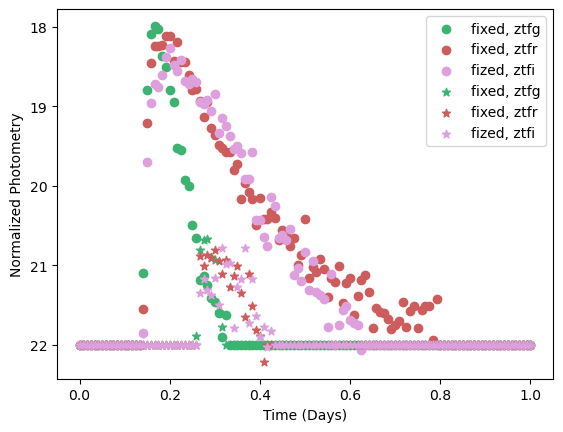

In [24]:
# checking normalization:

plt.scatter(np.linspace(0, 1, 121), data_unshifted_paper[0, 0, 0].numpy(), color = 'mediumseagreen', label = 'fixed, ztfg')
plt.scatter(np.linspace(0, 1, 121), data_unshifted_paper[0, 0, 1].numpy(), color = 'indianred', label = 'fixed, ztfr')
plt.scatter(np.linspace(0, 1, 121), data_unshifted_paper[0, 0, 2].numpy(), color = 'plum', label = 'fized, ztfi')

plt.scatter(np.linspace(0, 1, 121), data_shifted_paper[0, 0, 0].numpy(), color = 'mediumseagreen', label = 'fixed, ztfg', marker = '*')
plt.scatter(np.linspace(0, 1, 121), data_shifted_paper[0, 0, 1].numpy(), color = 'indianred', label = 'fixed, ztfr', marker = '*')
plt.scatter(np.linspace(0, 1, 121), data_shifted_paper[0, 0, 2].numpy(), color = 'plum', label = 'fized, ztfi', marker = '*')

plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Normalized Photometry')
plt.xlabel('Time (Days)')

In [25]:
global_mean = torch.mean(data_shifted_paper[data_shifted_paper != 22])
global_std = torch.std(data_shifted_paper[data_shifted_paper != 22])

print('mean ', global_mean, 'std ', global_std)

data_shifted_paper.sub_(global_mean).div_(global_std)
data_unshifted_paper.sub_(global_mean).div_(global_std)

mean  tensor(20.5056) std  tensor(1.0520)


tensor([[[[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205]],

         [[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205]],

         [[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205]],

         ...,

         [[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205]],

         [[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.42

Text(0.5, 0, 'Time (Days)')

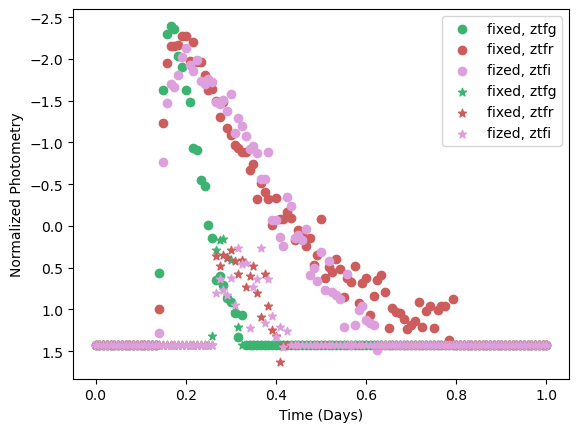

In [26]:
# after normalization:

plt.scatter(np.linspace(0, 1, 121), data_unshifted_paper[0, 0, 0].numpy(), color = 'mediumseagreen', label = 'fixed, ztfg')
plt.scatter(np.linspace(0, 1, 121), data_unshifted_paper[0, 0, 1].numpy(), color = 'indianred', label = 'fixed, ztfr')
plt.scatter(np.linspace(0, 1, 121), data_unshifted_paper[0, 0, 2].numpy(), color = 'plum', label = 'fized, ztfi')

plt.scatter(np.linspace(0, 1, 121), data_shifted_paper[0, 0, 0].numpy(), color = 'mediumseagreen', label = 'fixed, ztfg', marker = '*')
plt.scatter(np.linspace(0, 1, 121), data_shifted_paper[0, 0, 1].numpy(), color = 'indianred', label = 'fixed, ztfr', marker = '*')
plt.scatter(np.linspace(0, 1, 121), data_shifted_paper[0, 0, 2].numpy(), color = 'plum', label = 'fized, ztfi', marker = '*')

plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Normalized Photometry')
plt.xlabel('Time (Days)')

In [27]:
# define the dataset

dataset_paper = Paper_data(data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper, num_batches_paper_sample)

# check the dataset shape
_, t, d, _ = dataset_paper[4]
print(_.shape, t.shape, d.shape)

# split dataset into training, testing, and validation

num_batches_paper_sample = len(data_shifted_paper)

train_set_size_paper = int(0.8 * num_batches_paper_sample)    
val_set_size_paper = int(0.1 * num_batches_paper_sample)     
test_set_size_paper = num_batches_paper_sample - train_set_size_paper - val_set_size_paper

train_data_paper, val_data_paper, test_data_paper = torch.utils.data.random_split(
    dataset_paper, [train_set_size_paper, val_set_size_paper, test_set_size_paper])

# load and shuffle the data

train_data_loader_paper = DataLoader(train_data_paper, batch_size=100, shuffle=True)
val_data_loader_paper = DataLoader(val_data_paper, batch_size=100, shuffle=True)
test_data_loader_paper = DataLoader(test_data_paper, batch_size=1, shuffle=False)

# check lengths
print(len(train_data_loader_paper), len(test_data_loader_paper), len(val_data_loader_paper))

torch.Size([50, 3, 121]) torch.Size([50, 1, 5]) torch.Size([50, 3, 121])
70 874 9


# Training the Embedding

In [28]:
# set the embedding

num_dim = 7
similarity_embedding = SimilarityEmbedding(num_dim=num_dim, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5, expander_dim=175).to(device)

# optimizes
optimizer = optim.Adam(similarity_embedding.parameters(), lr=1.747064325271709e-05)

# sets learning rate steps
scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5) #constant lr
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3) #one cycle - increase and then decrease
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 15])

vicreg_loss = VICRegLoss()

writer = SummaryWriter("torchlogs/")
model = similarity_embedding
writer.close()

In [29]:
# %%time
# # training the neural network for many epochs

# epoch_number = 0
# EPOCHS = 50

# sim_val_loss = []
# sim_train_loss = []

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))

#     wt_repr, wt_cov, wt_std = (1, 1, 1)

#     print(f"VicReg wts: {wt_repr} {wt_cov} {wt_std}")
#     # Gradient tracking
#     similarity_embedding.train(True)
#     avg_train_loss = train_one_epoch_se(epoch_number, 
#                                         writer, 
#                                         train_data_loader_paper,
#                                         similarity_embedding,
#                                         optimizer,
#                                         vicreg_loss,
#                                         verbose = True,
#                                         wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
#     sim_train_loss.append(avg_train_loss)
    
#     # no gradient tracking, for validation
#     similarity_embedding.train(False)
#     similarity_embedding.eval()
#     avg_val_loss = val_one_epoch_se(epoch_number,
#                                     writer,
#                                     val_data_loader_paper,
#                                     similarity_embedding,
#                                     vicreg_loss, 
#                                     wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
#     sim_val_loss.append(avg_val_loss)
    
#     print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

#     epoch_number += 1
#     scheduler.step()

In [30]:
# # plot the train/val loss 

# epoch_list = range(0,len(sim_train_loss))
# plt.yscale('log')
# plt.plot(epoch_list, sim_train_loss, label = 'Similarity Embedding (Train)', color = 'royalblue', alpha = 0.8, marker = 's')
# plt.plot(epoch_list, sim_val_loss, label = 'Similarity Embedding (Val)', color = 'lightsteelblue', alpha=0.8, linestyle="dashed")
# plt.legend()
# plt.xlabel('Number of Epochs')
# plt.ylabel('Loss')

In [31]:
# load in weights

num_dim = 7
similarity_embedding = SimilarityEmbedding(num_dim=num_dim, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5, expander_dim=150).to(device)

SAVEPATH = '/nobackup/users/mmdesai/updated_weights/similarity-embedding-weights-allnorm-150layer-post-flow.pth'
similarity_embedding.load_state_dict(torch.load(SAVEPATH, map_location=device))

<All keys matched successfully>

In [32]:
shift_bounds = [
    [[1, 1, 1], [0.75, 0.75, 0.75]],
    [[0.75, 0.75, 0.75], [0.5, 0.5, 0.5]],
    [[0.5, 0.5, 0.5], [0.25, 0.25, 0.25]],
    [[0.25, 0.25, 0.25], [0, 0, 0]]
]

similarity_outputs = {}
data_loader = test_data_loader_paper

for divs in range(0, 4):
    reps_list = []
    for idx, (shift_var, shift_fix, data_var, data_fix) in enumerate(data_loader):
        shift_var = shift_var.reshape((-1,)+shift_var.shape[2:])
        shift_fix = shift_fix.reshape((-1,)+shift_fix.shape[2:])
        data_var = data_var.reshape((-1,)+data_var.shape[2:])
        data_fix = data_fix.reshape((-1,)+data_fix.shape[2:])
    
        if not ((shift_var[0][0][0] < shift_bounds[divs][0][0]) and (shift_var[0][0][0] > shift_bounds[divs][1][0])):
            continue
        if not ((shift_var[0][0][1] < shift_bounds[divs][0][1]) and (shift_var[0][0][1] > shift_bounds[divs][1][1])):
            continue
        if not ((shift_var[0][0][2] < shift_bounds[divs][0][2]) and (shift_var[0][0][2] > shift_bounds[divs][1][2])):
            continue
    
        with torch.no_grad():
            embed, rep = similarity_embedding(data_var)

        reps_list.append(rep)

    similarity_outputs['outputs_{}'.format(divs)] = reps_list

In [33]:
similarity_outputs_1 = torch.stack(similarity_outputs['outputs_0'])
similarity_outputs_2 = torch.stack(similarity_outputs['outputs_1'])
similarity_outputs_3 = torch.stack(similarity_outputs['outputs_2'])
similarity_outputs_4 = torch.stack(similarity_outputs['outputs_3'])

Text(0.02, 0.5, 'Embedding Space Dimensions')

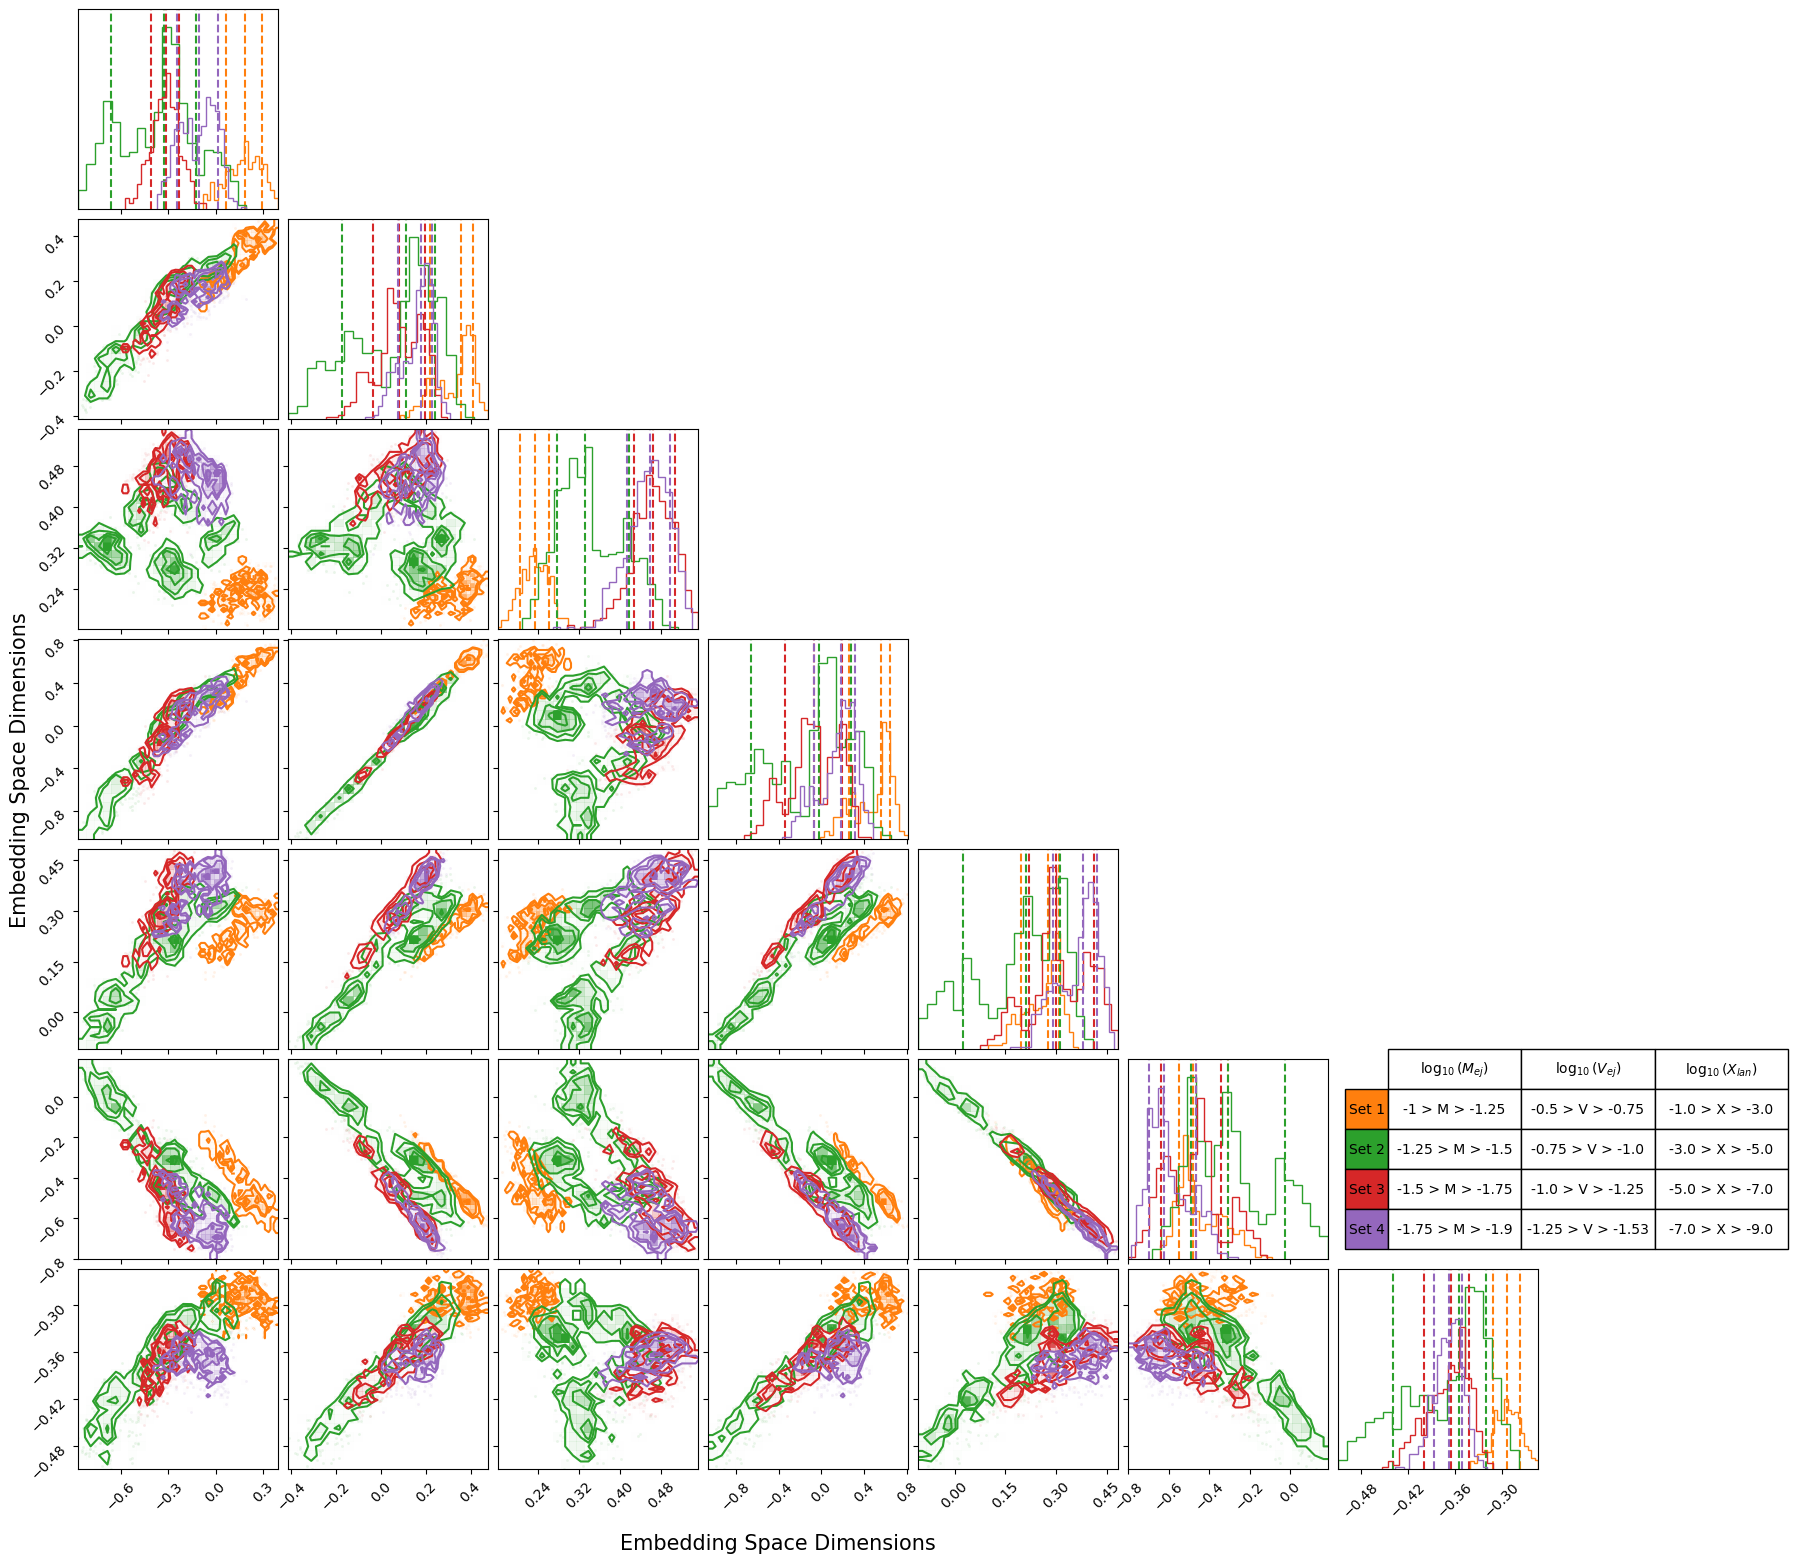

In [34]:
figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)
figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, 
    color="C2", # range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)
figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)
figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)

columns = [r'$\log_{10}(M_{ej})$', r'$\log_{10}(V_{ej})$', r'$\log_{10}(X_{lan})$']
rows = ['Set 1', 'Set 2', 'Set 3', 'Set 4']
data = [
    ['-1 > M > -1.25', '-0.5 > V > -0.75', '-1.0 > X > -3.0'],
    ['-1.25 > M > -1.5', '-0.75 > V > -1.0', '-3.0 > X > -5.0'],
    ['-1.5 > M > -1.75', '-1.0 > V > -1.25', '-5.0 > X > -7.0'],
    ['-1.75 > M > -1.9', '-1.25 > V > -1.53', '-7.0 > X > -9.0']
]

# Create table with custom row colors
line_colors = ['C1', 'C2', 'C3', 'C4']

# Create table
the_table = plt.table(cellText=data,
                      colLabels=columns,
                      rowLabels=rows,
                      cellLoc='center',
                      loc='upper right',
                      bbox=[0.25, 1.1, 2, 1])  # Adjust bbox for better placement

# Format the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.3, 1.3)  # Adjust the scaling to avoid squishing

# Set row colors
for i, color in enumerate(line_colors):
    the_table[(i+1, -1)].set_facecolor(color)  # Set background color for each row label
    # the_table[(i+1, 0)].set_facecolor(color)   # Set background color for each corresponding row

# Plot corresponding line handles so the table and lines are linked by color
handles = [mlines.Line2D([], [], color=color, label=f'Set {i+1}') for i, color in enumerate(line_colors)]

figure.supxlabel('Embedding Space Dimensions', fontsize = 15)
figure.supylabel('Embedding Space Dimensions', fontsize = 15)

#plt.savefig('fullprior_rep_pre_flow.pdf', format='pdf', bbox_inches='tight')

# Test Data

In [35]:
# load in the csv files
test_dir = '/home/mmdesai/'
test_df = load_in_data(test_dir, 'test', 4, num_repeats=1000)
test_df

t  ztfg  ztfr  ztfi  sim_id  num_detections    mej    vej  xlan  \
0        0.00  22.0  22.0  22.0       0              52 -1.125 -0.625 -3.75   
1        0.25  22.0  22.0  22.0       0              52 -1.125 -0.625 -3.75   
2        0.50  22.0  22.0  22.0       0              52 -1.125 -0.625 -3.75   
3        0.75  22.0  22.0  22.0       0              52 -1.125 -0.625 -3.75   
4        1.00  22.0  22.0  22.0       0              52 -1.125 -0.625 -3.75   
...       ...   ...   ...   ...     ...             ...    ...    ...   ...   
120995  29.00  22.0  22.0  22.0    3999              10 -1.875 -1.375 -8.25   
120996  29.25  22.0  22.0  22.0    3999              10 -1.875 -1.375 -8.25   
120997  29.50  22.0  22.0  22.0    3999              10 -1.875 -1.375 -8.25   
120998  29.75  22.0  22.0  22.0    3999              10 -1.875 -1.375 -8.25   
120999  30.00  22.0  22.0  22.0    3999              10 -1.875 -1.375 -8.25   

           shift    distance  batch_id  
0      -0.416813  186.251461         0  
1      -0.416813  186.251461         0  
2      -0.416813  186.251461         0  
3      -0.416813  186.251461         0  
4      -0.416813  186.251461         0  
...          ...         ...       ...  
120995  2.947423  194.406612         3  
120996  2.947423  194.406612         3  
120997  2.947423  194.406612         3  
120998  2.947423  194.406612         3  
120999  2.947423  194.406612         3  

[484000 rows x 12 columns]

In [36]:
# function for loading the data

def test_df_to_tensor(df_test, batches, num_repeats):
    data_shifted_list = []
    param_shifted_list = []

    for idx in tqdm(range(0, batches)):
        data_shifted = torch.tensor(df_test.loc[df_test['batch_id'] == idx].iloc[:, 1:4].values.reshape(num_repeats, num_points, num_channels), 
                                    dtype=torch.float32).transpose(1, 2)
        param_shifted = torch.tensor(df_test.loc[df_test['batch_id'] == idx].iloc[::num_points, 6:11].values, 
                                    dtype=torch.float32).unsqueeze(2).transpose(1,2)
        data_shifted_list.append(data_shifted)
        param_shifted_list.append(param_shifted)
        
    return data_shifted_list, param_shifted_list

In [37]:
# moving the data to tensors on gpu

num_batches_test = len(test_df['batch_id'].unique())
data_shifted_test, param_shifted_test = test_df_to_tensor(test_df, num_batches_test, 1000)

100%|██████████| 4/4 [00:00<00:00, 13.71it/s]


In [38]:
param_shifted_test_all = []

for i in range(len(param_shifted_test)):
    param_shifted_test_squeezed = torch.squeeze(param_shifted_test[i])

    param_shifted_test_squeezed[:, 0].sub_(mej_min).div_(mej_max - mej_min)
    param_shifted_test_squeezed[:, 1].sub_(vej_min).div_(vej_max - vej_min)
    param_shifted_test_squeezed[:, 2].sub_(xlan_min).div_(xlan_max - xlan_min)
    param_shifted_test_squeezed[:, 3].sub_(time_min).div_(time_max - time_min)
    param_shifted_test_squeezed[:, 4].sub_(dist_min).div_(dist_max - dist_min)

    param_shifted_test_unsqueezed = torch.unsqueeze(param_shifted_test_squeezed, 1)
    
    param_shifted_test_all.append(param_shifted_test_unsqueezed)


In [39]:
data_shifted_test_all = []

for i in range(len(data_shifted_test)):
    data_shifted_test_solo = data_shifted_test[i]
    data_shifted_test_solo.sub_(global_mean).div_(global_std)

    data_shifted_test_all.append(data_shifted_test_solo)

In [40]:
class Test_data(Dataset):
    def __len__(self):
        return (num_batches_test)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            param_shifted_test_all[idx].to(device),
            data_shifted_test_all[idx].to(device)
        )

In [41]:
# define dataset

test_dataset = Test_data()

t, d = test_dataset[0]
print(t.shape, d.shape)

torch.Size([1000, 1, 5]) torch.Size([1000, 3, 121])


In [42]:
similarity_outputs_1 = []
similarity_embedding.train(False)

for idx, (shift_test, data_test) in enumerate(test_dataset):
    if not ((shift_test[0][0][0] < 0.9) and (shift_test[0][0][0] > 0.8)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (shift_test, data_test) in enumerate(test_dataset):
    if not ((shift_test[0][0][0] < 0.6) and (shift_test[0][0][0] > 0.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (shift_test, data_test) in enumerate(test_dataset):
    if not ((shift_test[0][0][0] < 0.4) and (shift_test[0][0][0] > 0.3)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (shift_test, data_test) in enumerate(test_dataset):
    if not ((shift_test[0][0][0] < 0.2) and (shift_test[0][0][0] > 0)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)

In [43]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

/tmp/ipykernel_2909235/749050711.py:28: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.ticker.NullLocator'>
  ax.locator_params(axis='both', nbins=3)


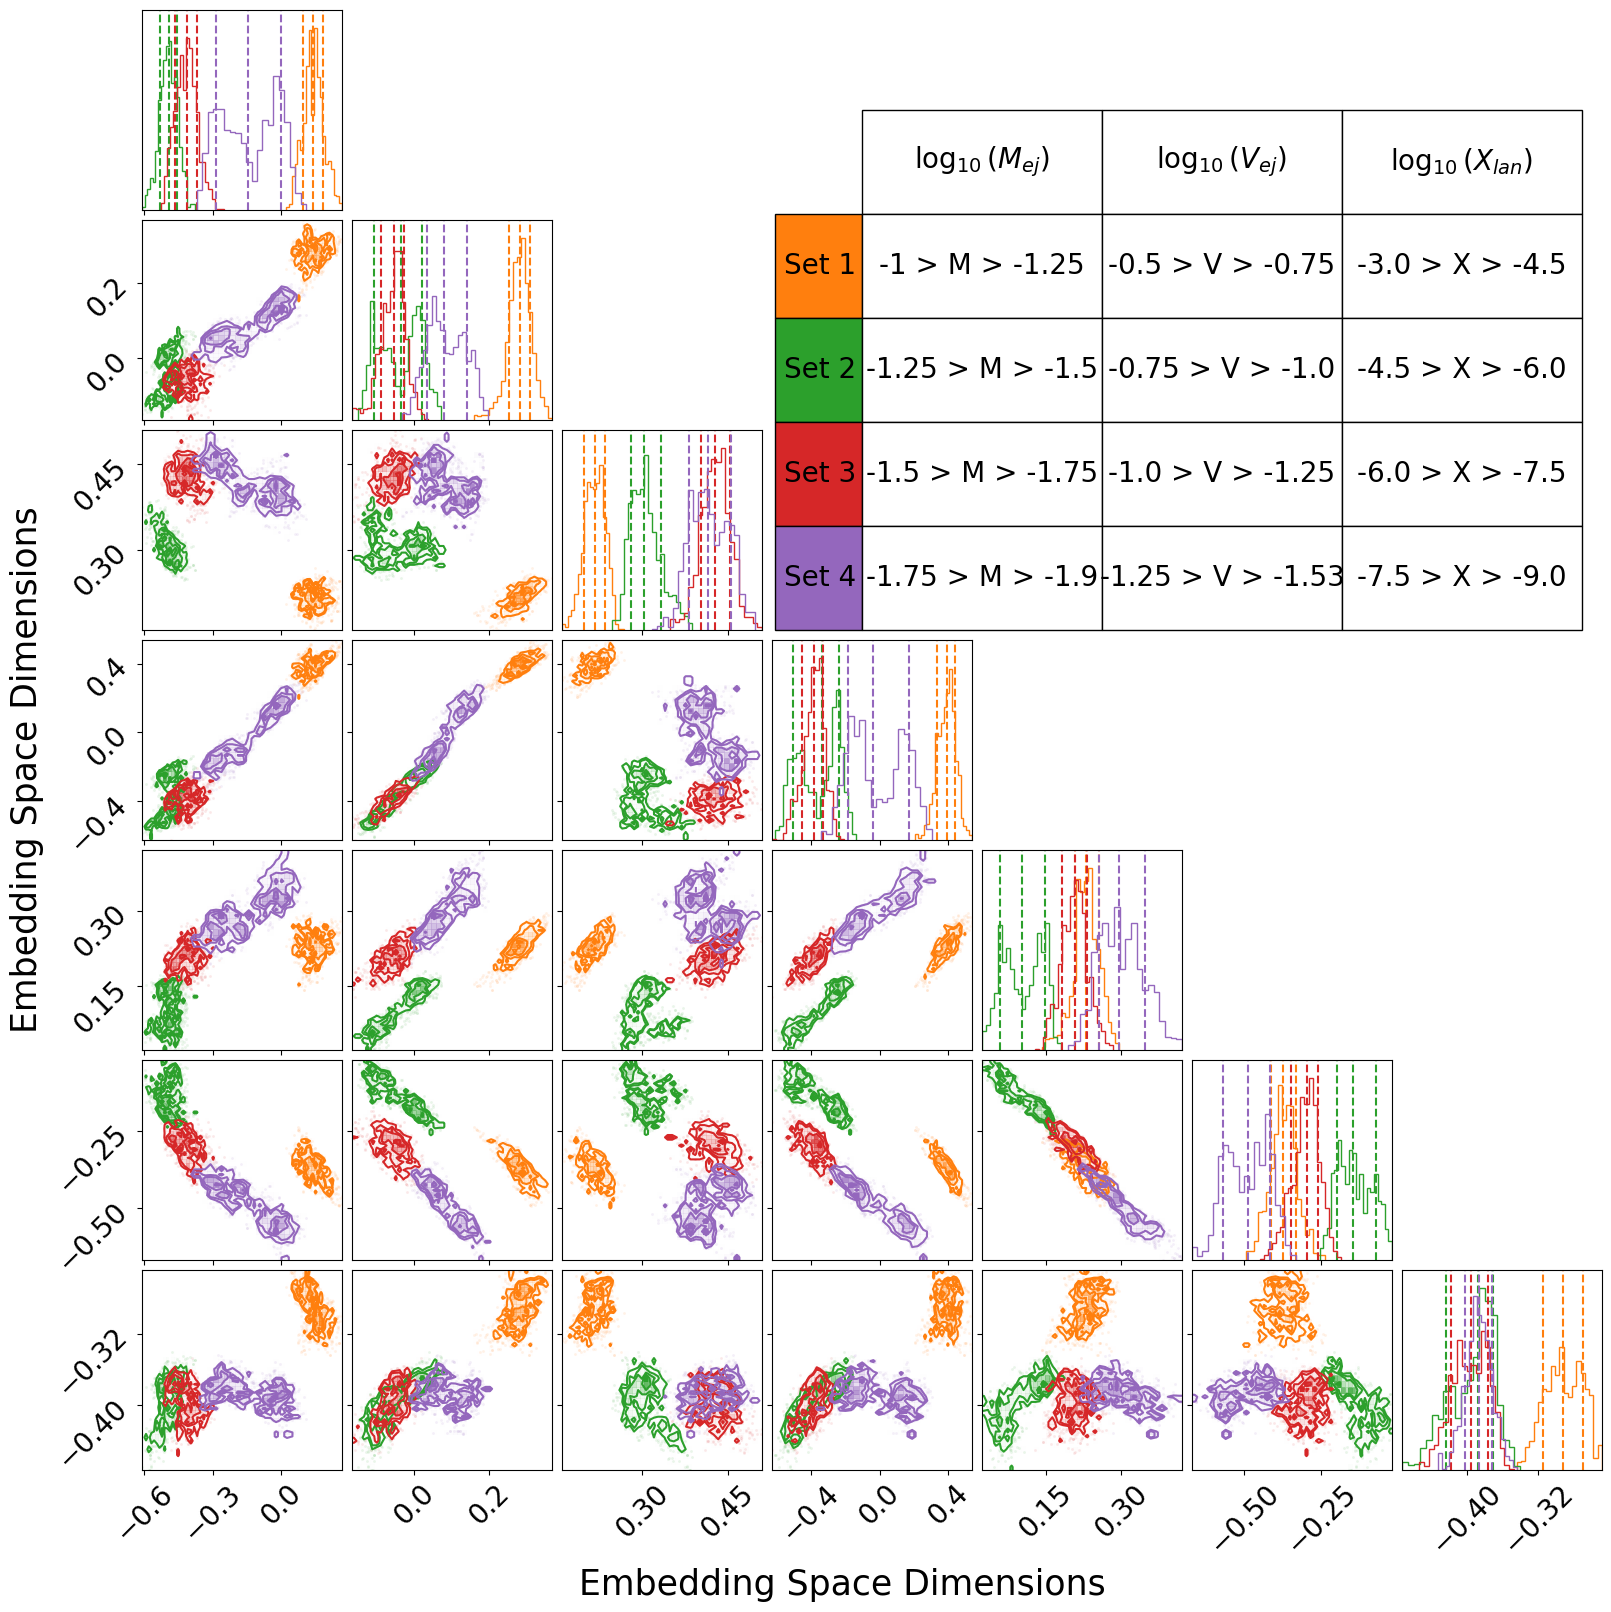

In [44]:
# import matplotlib.lines as mlines

figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2",
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4",
)

figure.supxlabel('Embedding Space Dimensions', fontsize = 25, y = -0.02)
figure.supylabel('Embedding Space Dimensions', fontsize = 25, x = -0.02)

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=20)
    ax.locator_params(axis='both', nbins=3)

columns = [r'$\log_{10}(M_{ej})$', r'$\log_{10}(V_{ej})$', r'$\log_{10}(X_{lan})$']
rows = ['Set 1', 'Set 2', 'Set 3', 'Set 4']
data = [
    ['-1 > M > -1.25', '-0.5 > V > -0.75', '-3.0 > X > -4.5'],
    ['-1.25 > M > -1.5', '-0.75 > V > -1.0', '-4.5 > X > -6.0'],
    ['-1.5 > M > -1.75', '-1.0 > V > -1.25', '-6.0 > X > -7.5'],
    ['-1.75 > M > -1.9', '-1.25 > V > -1.53', '-7.5 > X > -9.0']
]

# Create table with custom row colors
line_colors = ['C1', 'C2', 'C3', 'C4']

# Create table
the_table = plt.table(cellText=data,
                      colLabels=columns,
                      rowLabels=rows,
                      cellLoc='center',
                      loc='upper right',
                      bbox=[-2.7, 4.2, 3.6, 2.6])  # Adjust bbox for better placement

# Format the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(20)
the_table.scale(1.3, 1.3)  # Adjust the scaling to avoid squishing

# Set row colors
for i, color in enumerate(line_colors):
    the_table[(i+1, -1)].set_facecolor(color)  # Set background color for each row label
    # the_table[(i+1, 0)].set_facecolor(color)   # Set background color for each corresponding row

# Plot corresponding line handles so the table and lines are linked by color
handles = [mlines.Line2D([], [], color=color, label=f'Set {i+1}') for i, color in enumerate(line_colors)]

#plt.savefig('pretuningrep_testlc_notnormalized_150.pdf', format='pdf', bbox_inches='tight')

In [45]:
similarity_outputs_5 = []
similarity_embedding.train(False)

for idx, (shift_test, data_test) in enumerate(test_dataset):
    if not ((shift_test[0][0][0] < 0.9) and (shift_test[0][0][0] > 0.8)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_5.append(similarity_output)

similarity_outputs_6 = []

for idx, (shift_test, data_test) in enumerate(test_dataset):
    if not ((shift_test[0][0][0] < 0.6) and (shift_test[0][0][0] > 0.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_6.append(similarity_output)

similarity_outputs_7 = []

for idx, (shift_test, data_test) in enumerate(test_dataset):
    if not ((shift_test[0][0][0] < 0.4) and (shift_test[0][0][0] > 0.3)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_7.append(similarity_output)

similarity_outputs_8 = []

for idx, (shift_test, data_test) in enumerate(test_dataset):
    if not ((shift_test[0][0][0] < 0.2) and (shift_test[0][0][0] > 0)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_8.append(similarity_output)

In [46]:
similarity_outputs_5 = torch.stack(similarity_outputs_5)
similarity_outputs_6 = torch.stack(similarity_outputs_6)
similarity_outputs_7 = torch.stack(similarity_outputs_7)
similarity_outputs_8 = torch.stack(similarity_outputs_8)

/tmp/ipykernel_2909235/870172693.py:26: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.ticker.NullLocator'>
  ax.locator_params(axis='both', nbins=3)


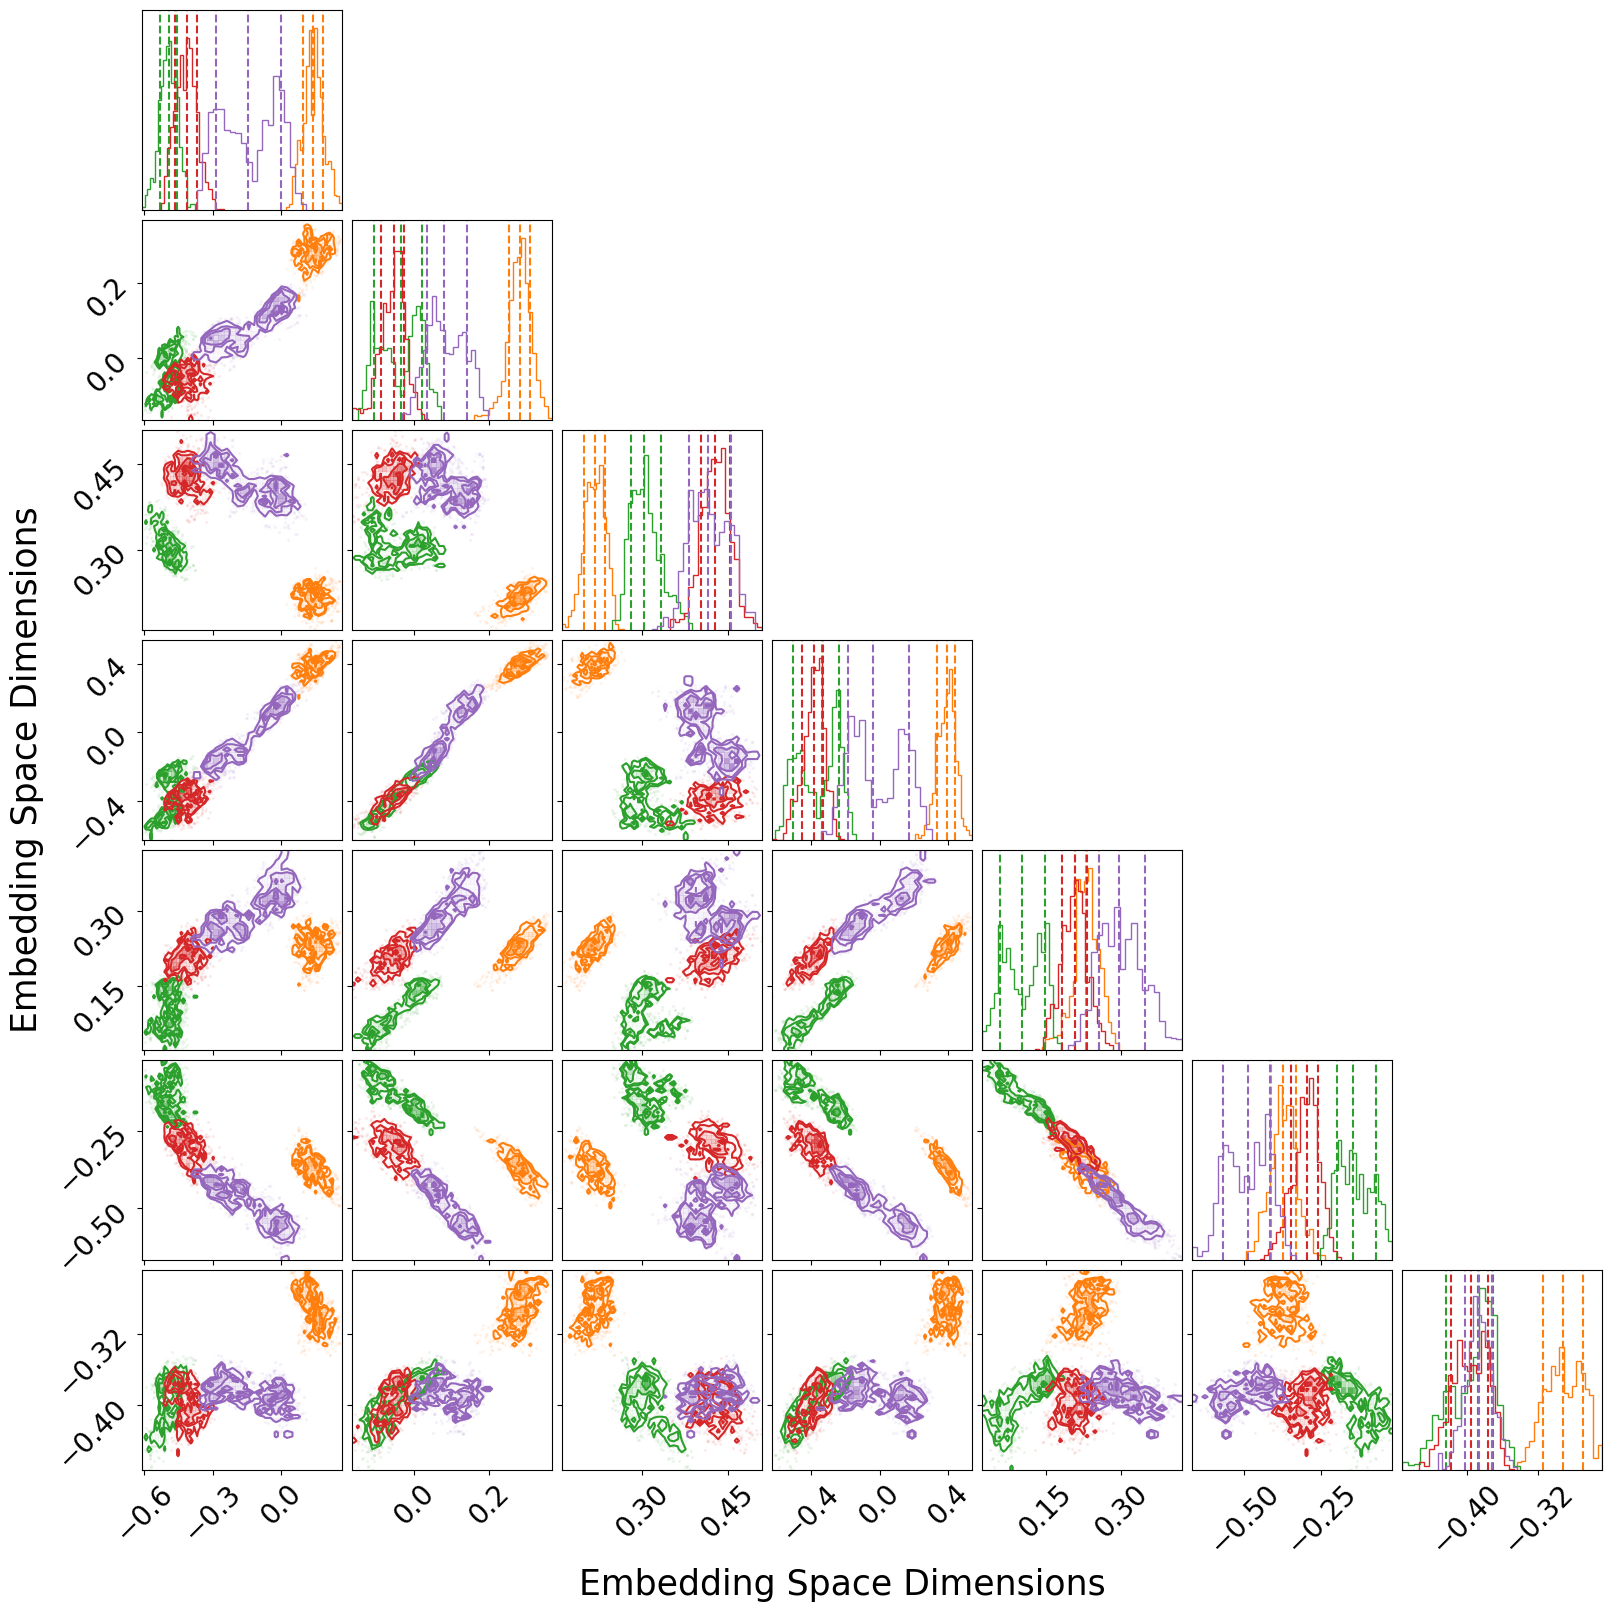

In [47]:
figure = corner.corner(
    similarity_outputs_5.cpu().numpy().reshape((similarity_outputs_5.shape[0]*similarity_outputs_5.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1", reverse = False, 
)

figure = corner.corner(
    similarity_outputs_6.cpu().numpy().reshape((similarity_outputs_6.shape[0]*similarity_outputs_6.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2", reverse = False,
)

figure = corner.corner(
    similarity_outputs_7.cpu().numpy().reshape((similarity_outputs_7.shape[0]*similarity_outputs_7.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3", reverse = False,
)

figure = corner.corner(
    similarity_outputs_8.cpu().numpy().reshape((similarity_outputs_8.shape[0]*similarity_outputs_8.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4", reverse = False,
)

figure.supxlabel('Embedding Space Dimensions', fontsize = 25, y = -0.02)
figure.supylabel('Embedding Space Dimensions', fontsize = 25, x = -0.02)

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=20)
    ax.locator_params(axis='both', nbins=3)

#plt.savefig('posttuningrep-normalized-150layer.pdf', format='pdf', bbox_inches='tight')

# Save Embedding Weights

In [48]:
# # Save the weights

# SAVEPATH = '/nobackup/users/mmdesai/similarity-embedding-weights-150-pre-flow-423.pth'
# torch.save(similarity_embedding.state_dict(), SAVEPATH)

# Normalizing Flow

In [49]:
data_shifted_flow1 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/data_shifted_flow_1.pt')
param_shifted_flow1 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/param_shifted_flow_1.pt')
data_shifted_flow2 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/data_shifted_flow_2.pt')
param_shifted_flow2 = torch.load('/nobackup/users/mmdesai/zenodo_tensors/param_shifted_flow_2.pt')

In [50]:
data_shifted_flow = torch.stack(data_shifted_flow1 + data_shifted_flow2)
param_shifted_flow = torch.stack(param_shifted_flow1 + param_shifted_flow2)

In [51]:
num_lc_flow = len(data_shifted_flow)
print(num_lc_flow)

9446


In [52]:
data_shifted_flow[0].shape, param_shifted_flow[0].shape

(torch.Size([50, 3, 121]), torch.Size([50, 1, 5]))

In [53]:
# normalize the parameters

param_shifted_flow_squeezed = torch.squeeze(param_shifted_flow)
print(param_shifted_flow_squeezed.shape)

param_shifted_flow_squeezed[:, :, 0].sub_(mej_min).div_(mej_max - mej_min)
param_shifted_flow_squeezed[:, :, 1].sub_(vej_min).div_(vej_max - vej_min)
param_shifted_flow_squeezed[:, :, 2].sub_(xlan_min).div_(xlan_max - xlan_min)
param_shifted_flow_squeezed[:, :, 3].sub_(time_min).div_(time_max - time_min)
param_shifted_flow_squeezed[:, :, 4].sub_(dist_min).div_(dist_max - dist_min)

torch.Size([9446, 50, 5])


tensor([[0.0723, 0.4083, 0.2968,  ..., 0.9680, 0.3894, 0.7847],
        [0.7954, 0.4806, 0.9337,  ..., 0.4778, 0.9350, 0.9375],
        [0.6928, 0.1466, 0.8648,  ..., 0.0749, 0.9476, 0.4136],
        ...,
        [0.2458, 0.8665, 0.2892,  ..., 0.2126, 0.1138, 0.1904],
        [0.8812, 0.0246, 0.3338,  ..., 0.3916, 0.5542, 0.4464],
        [0.0315, 0.3109, 0.4213,  ..., 0.5770, 0.2118, 0.7646]])

In [54]:
param_shifted_flow_unsqueezed = torch.unsqueeze(param_shifted_flow_squeezed, 2)
param_shifted_flow_unsqueezed.shape

torch.Size([9446, 50, 1, 5])

In [55]:
data_shifted_flow.sub_(global_mean).div_(global_std)

tensor([[[[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205]],

         [[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205]],

         [[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205]],

         ...,

         [[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205]],

         [[1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.4205, 1.4205],
          [1.4205, 1.4205, 1.4205,  ..., 1.4205, 1.42

In [56]:
class Flow_data(Dataset):
    def __len__(self):
        return (num_lc_flow)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            param_shifted_flow[idx].to(device),
            data_shifted_flow[idx].to(device)
        )

In [57]:
dataset_normflow = Flow_data()

# check the dataset shape
t, d = dataset_normflow[4]
t.shape, d.shape

(torch.Size([50, 1, 5]), torch.Size([50, 3, 121]))

In [58]:
# split dataset into training, testing, and validation

train_set_size_flow = int(0.8 * num_lc_flow)    
val_set_size_flow = int(0.1 * num_lc_flow)     
test_set_size_flow = num_lc_flow - train_set_size_flow - val_set_size_flow

train_data_flow, val_data_flow, test_data_flow = torch.utils.data.random_split(
    dataset_normflow, [train_set_size_flow, val_set_size_flow, test_set_size_flow])

In [59]:
# load and shuffle the data

train_data_loader_flow = DataLoader(train_data_flow, batch_size=25, shuffle=True)
val_data_loader_flow = DataLoader(val_data_flow, batch_size=25, shuffle=True)
test_data_loader_flow = DataLoader(test_data_flow, batch_size=1, shuffle=False)

# check lengths
len(train_data_loader_flow), len(test_data_loader_flow), len(val_data_loader_flow)

(303, 946, 38)

In [60]:
# check first instance of data

for var_inj, var_data in train_data_loader_flow:
    print(var_inj.shape, var_data.shape)
    var_inj = var_inj.reshape((-1,)+var_inj.shape[2:])
    var_data = var_data.reshape((-1,)+var_data.shape[2:])

    break
var_inj.shape, var_data.shape

torch.Size([25, 50, 1, 5]) torch.Size([25, 50, 3, 121])


(torch.Size([1250, 1, 5]), torch.Size([1250, 3, 121]))

In [61]:
# make embeddeding net untrainable
for name, param in similarity_embedding.named_parameters():
    param.requires_grad = False

In [62]:
class EmbeddingNet(nn.Module):
    """Wrapper around the similarity embedding defined above"""
    #def __init__(self, *args, **kwargs):
    def __init__(self, similarity_embedding, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.representation_net = similarity_embedding
        self.representation_net.load_state_dict(similarity_embedding.state_dict())
        # self.num_dim = num_dim
        # the expander network is unused and hence don't track gradients
        for name, param in self.representation_net.named_parameters():
            if 'expander_layer' in name or 'layers_h' in name or 'final_layer' in name:
                param.requires_grad = True
        # set freeze status of part of the conv layer of embedding_net
            elif 'layers_f' in name:
                param.requires_grad = True
            else:
                param.requires_grad = True
        self.context_layer = nn.Sequential(
            nn.Linear(num_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_dim)
            )
        
    def forward(self, x):
        # print('initial shape', x.shape)
        batch_size, channels, dims = x.shape
        _, rep = self.representation_net(x) # 500, 3, 191 -> 500, 1, 2
        rep = rep.reshape(batch_size, num_dim)

        return self.context_layer(rep)

In [63]:
for var_inj_se, var_data_se in train_data_loader_flow:
    var_inj_se = var_inj_se.reshape((-1,)+var_inj_se.shape[2:]).to(device)
    var_data_se = var_data_se.reshape((-1,)+var_data_se.shape[2:]).to(device)
    break

# check shapes
print(var_data_se.shape, var_inj_se.shape)
_, rep = similarity_embedding(var_data_se)  # _.shape = batch_size x 1 x 10, # rep.shape = batch_size x 1 x 2
print(_.shape, rep.shape)
context_features = rep.shape[-1]
print('number of context_features: ', context_features)
print('number of dimensions: ', num_dim)

torch.Size([1250, 3, 121]) torch.Size([1250, 1, 5])
torch.Size([1250, 5]) torch.Size([1250, 7])
number of context_features:  7
number of dimensions:  7


In [64]:
def normflow_params(similarity_embedding, num_transforms, num_blocks, hidden_features, context_features, num_dim):
    base_dist = StandardNormal([3])
    transforms = []
    features = 3
    for _ in range(num_transforms):
        block = [MaskedAffineAutoregressiveTransform(
                features=features,  
                hidden_features=hidden_features,  # 80
                context_features=context_features,  # 5
                num_blocks=num_blocks,   # 5
                activation=torch.tanh,
                use_batch_norm=False,
                use_residual_blocks=True,
                dropout_probability=0.01,
    #             integrand_net_layers=[20, 20]
            ),
            RandomPermutation(features=features)
        ]
        transforms += block
    transform = CompositeTransform(transforms)
    embedding_net = EmbeddingNet(similarity_embedding)
    return transform, base_dist, embedding_net

In [65]:
transform, base_dist, embedding_net = normflow_params(similarity_embedding, num_transforms=9, num_blocks=5, hidden_features=90, context_features=context_features, num_dim=num_dim) 

In [66]:
flow = Flow(transform, base_dist, embedding_net).to(device=device)

In [67]:
print('Total number of trainable parameters: ', sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  1218175


In [68]:
def train_one_epoch(epoch_index, tb_writer, data_loader, flow, optimizer, flatten_dim):
    running_loss = 0.
    last_loss = 0.
    for idx, val in enumerate(data_loader, 1):
        augmented_shift, augmented_data = val
        augmented_shift = augmented_shift[..., 0:3].to(device)
        augmented_shift = augmented_shift.flatten(0, flatten_dim).to(device)
        augmented_data = augmented_data.reshape(-1, 3, num_points).to(device)
        
        loss = 0
        flow_loss = -flow.log_prob(augmented_shift, context=augmented_data).mean()
        optimizer.zero_grad()
        flow_loss.backward()
        optimizer.step()
        loss += flow_loss.item()
        running_loss += loss
        n = 10
        if idx % n == 0:
            last_loss = running_loss / n
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss

In [69]:
def val_one_epoch(epoch_index, tb_writer, data_loader, flow, flatten_dim):
    running_loss = 0.
    last_loss = 0.
    for idx, val in enumerate(data_loader, 1):
        augmented_shift, augmented_data = val
        augmented_shift = augmented_shift[..., 0:3].to(device)
        augmented_shift = augmented_shift.flatten(0, flatten_dim).to(device)
        augmented_data = augmented_data.reshape(-1, 3, num_points).to(device)
        loss = 0
        flow_loss = -flow.log_prob(augmented_shift, context=augmented_data).mean()
        loss += flow_loss.item()
        running_loss += loss
        n = 1
        if idx % n == 0:
            last_loss = running_loss / n
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [70]:
# optimizer
optimizer = optim.SGD(flow.parameters(), lr=0.0000912, momentum=0.5)
# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, threshold=0.001)

In [71]:
writer = SummaryWriter()

In [72]:
# %%time
# # UNCOMMENT AND RUN TO TRAIN FROM SCRATCH

# train_loss_list = []
# val_loss_list = []

# EPOCHS = 100
# epoch_number = 0
# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     flow.train(True)
#     for name, param in flow._embedding_net.named_parameters():
#         param.requires_grad = True
#     avg_train_loss = train_one_epoch(epoch_number, writer, train_data_loader_flow, flow, optimizer, 2)
#     train_loss_list.append(avg_train_loss)
#     flow.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer, val_data_loader_flow, flow, 2)
#     val_loss_list.append(avg_val_loss)
#     print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
#     epoch_number += 1
#     scheduler.step(avg_val_loss)
#     for param_group in optimizer.param_groups:
#         print("Current LR = {:.3e}".format(param_group['lr']))

In [73]:
# # save the experimental train/val loss for untrained network 

# untrainedtrainloss_file = open("untrained_train_loss2.txt", "w")
# untrainedtrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# untrainedtrainloss_file.close()

# untrainedvalloss_file = open("untrained_val_loss2.txt", "w")
# untrainedvalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# untrainedvalloss_file.close()

with open("untrained_train_loss2.txt") as f:
    untrained_train_loss_list = eval(f.read())

with open("untrained_val_loss2.txt") as f:
    untrained_val_loss_list = eval(f.read())

In [74]:
# save the experimental train/val loss for frozen network 

# frozentrainloss_file = open("frozen_train_loss_tuned.txt", "w")
# frozentrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# frozentrainloss_file.close()

# frozenvalloss_file = open("frozen_val_loss_tuned.txt", "w")
# frozenvalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# frozenvalloss_file.close()

with open("frozen_train_loss_tuned.txt") as f:
    frozen_train_loss_list = eval(f.read())

with open("frozen_val_loss_tuned.txt") as f:
    frozen_val_loss_list = eval(f.read())

In [75]:
# save the train/val loss for similarity embedding (completely unfrozen)

# unfrozentrainloss_file = open("unfrozen_train_loss.txt", "w")
# unfrozentrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# unfrozentrainloss_file.close()

# unfrozenvalloss_file = open("unfrozen_val_loss.txt", "w")
# unfrozenvalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# unfrozenvalloss_file.close()

with open("unfrozen_train_loss.txt") as f:
    unfrozen_train_loss_list = eval(f.read())

with open("unfrozen_val_loss.txt") as f:
    unfrozen_val_loss_list = eval(f.read())


In [76]:
# save the train/val loss for partial similarity embedding -- CORRECT, KEEP AS PARTIALLY FROZEN

# partiallyfrozentrainloss_file = open("partially_frozen_train_loss_norm.txt", "w")
# partiallyfrozentrainloss_file.writelines(str(train_loss_list))
# print("user data successfully saved to file")
# partiallyfrozentrainloss_file.close()

# partiallyfrozenvalloss_file = open("partially_frozen_val_loss_norm.txt", "w")
# partiallyfrozenvalloss_file.writelines(str(val_loss_list))
# print("user data successfully saved to file")
# partiallyfrozenvalloss_file.close()

with open("partially_frozen_train_loss_norm.txt") as f:
    partially_frozen_train_loss_list = eval(f.read())

with open("partially_frozen_val_loss_norm.txt") as f:
    partially_frozen_val_loss_list = eval(f.read())

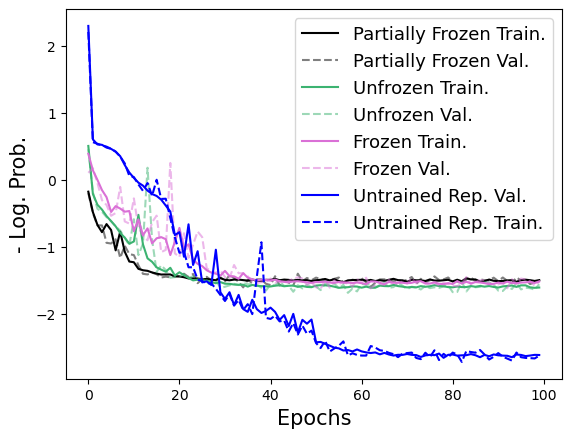

In [77]:
# plot the comparision of the train/val loss for the three scenarios

epoch_length = 100
epoch_list = range(0,epoch_length)

# plt.plot(epoch_list[:len(train_loss_list)], train_loss_list[:len(train_loss_list)], label = 'Current Run', color = 'k')
# plt.plot(epoch_list[:len(val_loss_list)], val_loss_list[:len(val_loss_list)], label = 'Validation', color = 'k', linestyle = 'dashed')
plt.plot(epoch_list, partially_frozen_train_loss_list[:epoch_length], label = 'Partially Frozen Train.', color ='k', alpha=1)
plt.plot(epoch_list, partially_frozen_val_loss_list[:epoch_length], label = 'Partially Frozen Val.', color = 'k', alpha=0.5, linestyle='dashed')
plt.plot(epoch_list, unfrozen_train_loss_list[:epoch_length], label = 'Unfrozen Train.', color = 'mediumseagreen', alpha=1)
plt.plot(epoch_list, unfrozen_val_loss_list[:epoch_length], label = 'Unfrozen Val.', color = 'mediumseagreen', alpha=0.5, linestyle='dashed')
plt.plot(epoch_list, frozen_train_loss_list[:epoch_length], label = 'Frozen Train.', color = 'orchid', alpha=1)
plt.plot(epoch_list, frozen_val_loss_list[:epoch_length], label = 'Frozen Val.', color = 'orchid', alpha=0.5, linestyle='dashed')
plt.plot(epoch_list, untrained_train_loss_list[:epoch_length], label = 'Untrained Rep. Val.', color = 'blue', alpha=1)
plt.plot(epoch_list, untrained_val_loss_list[:epoch_length], label='Untrained Rep. Train.', color='blue', alpha=1, linestyle="dashed")
plt.ylabel('- Log. Prob.', fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.legend(fontsize = 13)
#plt.savefig('flowlosscurves.pdf', format="pdf", bbox_inches="tight")

In [78]:
# load the final weights - use this one updated

PATH_nflow = '/nobackup/users/mmdesai/partially-frozen-flow-weights-allnorm-150layer.pth'
flow.load_state_dict(torch.load(PATH_nflow, map_location=device))

<All keys matched successfully>

# Testing Data

## Varied

In [81]:
final_test_path = '/nobackup/users/mmdesai/test_lc_sup'
file_names = [] 

for i in range (0, 100):
    # file_name = final_test_path + '/varied_test_0_{}.json'.format(i)
    file_name = final_test_path + '/test_var_{}.json'.format(i)
    file_names.append(file_name)
test_lc_list = json_to_df(file_names, 100)
test_lc_list_padded = pad_all_dfs(test_lc_list)

100%|██████████| 100/100 [00:00<00:00, 281.56it/s]


In [82]:
inj_path_simembed = '/nobackup/users/mmdesai/test_lc_sup'

test_inj_df = pd.DataFrame()
# test_params = open_json('/injection_test_varied_0.json', inj_path_simembed)
test_params = open_json('/injection_test_var.json', inj_path_simembed)
test_inj_df['mej'] = test_params['injections']['content']['log10_mej']
test_inj_df['vej'] = test_params['injections']['content']['log10_vej']
test_inj_df['xlan'] = test_params['injections']['content']['log10_Xlan']
test_inj_df['shift'] = test_params['injections']['content']['timeshift']
test_inj_df['distance'] = test_params['injections']['content']['luminosity_distance']
test_inj_df['sim_id'] = test_params['injections']['content']['simulation_id']

In [83]:
test_inj_df

mej       vej      xlan     shift    distance  sim_id
0  -1.849209 -1.260331 -6.357472  2.644349   94.608541       0
1  -1.464203 -0.857283 -5.492559 -1.327980  135.550326       1
2  -1.731380 -0.930661 -4.569269  1.963130  136.939901       2
3  -1.646248 -1.508423 -4.367395 -1.775502  199.256637       3
4  -1.394940 -0.575934 -3.795453  3.159888  148.637063       4
..       ...       ...       ...       ...         ...     ...
95 -1.601587 -1.440944 -6.885429 -1.084447  186.164037      95
96 -1.837545 -0.853185 -7.702620  4.042358  142.066057      96
97 -1.661875 -0.784736 -8.515978  3.495882  104.451419      97
98 -1.256268 -1.416250 -8.446431  1.239364  149.159402      98
99 -1.430267 -0.985723 -8.495553  0.003071  192.209710      99

[100 rows x 6 columns]

In [84]:
test_lc_df = pd.concat(test_lc_list_padded)
test_data_df = test_lc_df.merge(test_inj_df, on = 'sim_id')
test_data_df

t  ztfg  ztfr  ztfi  sim_id  num_detections       mej       vej  \
0       0.00  22.0  22.0  22.0       0              65 -1.849209 -1.260331   
1       0.25  22.0  22.0  22.0       0              65 -1.849209 -1.260331   
2       0.50  22.0  22.0  22.0       0              65 -1.849209 -1.260331   
3       0.75  22.0  22.0  22.0       0              65 -1.849209 -1.260331   
4       1.00  22.0  22.0  22.0       0              65 -1.849209 -1.260331   
...      ...   ...   ...   ...     ...             ...       ...       ...   
12095  29.00  22.0  22.0  22.0      99              61 -1.430267 -0.985723   
12096  29.25  22.0  22.0  22.0      99              61 -1.430267 -0.985723   
12097  29.50  22.0  22.0  22.0      99              61 -1.430267 -0.985723   
12098  29.75  22.0  22.0  22.0      99              61 -1.430267 -0.985723   
12099  30.00  22.0  22.0  22.0      99              61 -1.430267 -0.985723   

           xlan     shift    distance  
0     -6.357472  2.644349   94.608541  
1     -6.357472  2.644349   94.608541  
2     -6.357472  2.644349   94.608541  
3     -6.357472  2.644349   94.608541  
4     -6.357472  2.644349   94.608541  
...         ...       ...         ...  
12095 -8.495553  0.003071  192.209710  
12096 -8.495553  0.003071  192.209710  
12097 -8.495553  0.003071  192.209710  
12098 -8.495553  0.003071  192.209710  
12099 -8.495553  0.003071  192.209710  

[12100 rows x 11 columns]

In [85]:
test_data_shifted = []
test_param_shifted = []

for idx in tqdm(range(0, 100)):
    data_shifted = torch.tensor(test_data_df.loc[test_data_df['sim_id'] == idx].iloc[:, 1:4].values.reshape(1, num_points, num_channels),
                                dtype=torch.float32).transpose(1, 2)
    param_shifted = torch.tensor(test_data_df.loc[test_data_df['sim_id'] == idx].iloc[::num_points, 6:11].values, 
                                dtype=torch.float32).unsqueeze(2).transpose(1,2)
    test_data_shifted.append(data_shifted)
    test_param_shifted.append(param_shifted)

100%|██████████| 100/100 [00:00<00:00, 740.45it/s]


In [86]:
test_param_shifted_all = []

for i in range(len(test_param_shifted)):
    new_norm_test_tensor = torch.clone(test_param_shifted[i])
    param_shifted_test_squeezed = torch.squeeze(new_norm_test_tensor, 0)
    
    param_shifted_test_squeezed[:, 0].sub_(mej_min).div_(mej_max - mej_min)
    param_shifted_test_squeezed[:, 1].sub_(vej_min).div_(vej_max - vej_min)
    param_shifted_test_squeezed[:, 2].sub_(xlan_min).div_(xlan_max - xlan_min)
    param_shifted_test_squeezed[:, 3].sub_(time_min).div_(time_max - time_min)
    param_shifted_test_squeezed[:, 4].sub_(dist_min).div_(dist_max - dist_min)

    param_shifted_test_unsqueezed = torch.unsqueeze(param_shifted_test_squeezed, 0)
    
    test_param_shifted_all.append(param_shifted_test_unsqueezed)

In [87]:
test_data_shifted_all = []

for i in range(len(test_data_shifted)):
    data_shifted_test_solo = test_data_shifted[i]
    data_shifted_test_solo.sub_(global_mean).div_(global_std)

    test_data_shifted_all.append(data_shifted_test_solo)

In [88]:
class Test_inf_data(Dataset):
    def __len__(self):
        return (100)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            test_data_shifted_all[idx].to(device),
            test_param_shifted[idx].to(device),
            test_param_shifted_all[idx].to(device),
            # test_data_shifted[idx].to(device),
            # test_param_shifted[idx].to(device),
            # test_param_shifted[idx].to(device),
        )

In [89]:
# define dataset

test_inf_dataset = Test_inf_data()

t, d, p = test_inf_dataset[0]
print(t.shape, d.shape, p.shape)

torch.Size([1, 3, 121]) torch.Size([1, 1, 5]) torch.Size([1, 1, 5])


In [90]:
# get the varied test light curves

var_inf_dict = {}
for i in range (0, len(test_inf_dataset)):
    var_inf_dict['var_data{}'.format(i)], var_inf_dict['var_param{}'.format(i)], var_inf_dict['norm_param{}'.format(i)] = test_inf_dataset[i]

In [91]:
var_inf_dict['var_param0']

tensor([[[-1.8492, -1.2603, -6.3575,  2.6443, 94.6085]]], device='cuda:0')

In [92]:
var_inf_dict['norm_param0']

tensor([[[0.0564, 0.2622, 0.4405, 0.5805, 0.2974]]], device='cuda:0')

In [93]:
var_inf_dict['var_param99']

tensor([[[-1.4303e+00, -9.8572e-01, -8.4956e+00,  3.0710e-03,  1.9221e+02]]],
       device='cuda:0')

In [94]:
var_inf_dict['norm_param99']

tensor([[[0.5219, 0.5397, 0.0841, 0.2504, 0.9481]]], device='cuda:0')

## Fixed

In [95]:
# get the test data

final_test_path = '/nobackup/users/mmdesai/test_lc_sup'
file_names = [] 

for i in range (0, 100):
    file_name = final_test_path + '/test_fix_{}.json'.format(i)
    file_names.append(file_name)
test_lc_list_fix = json_to_df(file_names, 100)
test_lc_list_padded_fix = pad_all_dfs(test_lc_list_fix)

100%|██████████| 100/100 [00:00<00:00, 275.58it/s]


In [96]:
inj_path_simembed = '/nobackup/users/mmdesai/test_lc_sup'

test_inj_df_fix = pd.DataFrame()
test_params = open_json('/injection_test_fix.json', inj_path_simembed)
test_inj_df_fix['mej'] = test_params['injections']['content']['log10_mej']
test_inj_df_fix['vej'] = test_params['injections']['content']['log10_vej']
test_inj_df_fix['xlan'] = test_params['injections']['content']['log10_Xlan']
test_inj_df_fix['shift'] = test_params['injections']['content']['timeshift']
test_inj_df_fix['distance'] = test_params['injections']['content']['luminosity_distance']
test_inj_df_fix['sim_id'] = test_params['injections']['content']['simulation_id']

In [97]:
test_lc_df_fix = pd.concat(test_lc_list_padded_fix)
test_data_df_fix = test_lc_df_fix.merge(test_inj_df_fix, on = 'sim_id')
test_data_df_fix

t  ztfg  ztfr  ztfi  sim_id  num_detections       mej       vej  \
0       0.00  22.0  22.0  22.0       0             119 -1.849209 -1.260331   
1       0.25  22.0  22.0  22.0       0             119 -1.849209 -1.260331   
2       0.50  22.0  22.0  22.0       0             119 -1.849209 -1.260331   
3       0.75  22.0  22.0  22.0       0             119 -1.849209 -1.260331   
4       1.00  22.0  22.0  22.0       0             119 -1.849209 -1.260331   
...      ...   ...   ...   ...     ...             ...       ...       ...   
12095  29.00  22.0  22.0  22.0      99             194 -1.430267 -0.985723   
12096  29.25  22.0  22.0  22.0      99             194 -1.430267 -0.985723   
12097  29.50  22.0  22.0  22.0      99             194 -1.430267 -0.985723   
12098  29.75  22.0  22.0  22.0      99             194 -1.430267 -0.985723   
12099  30.00  22.0  22.0  22.0      99             194 -1.430267 -0.985723   

           xlan  shift  distance  
0     -6.357472      0        50  
1     -6.357472      0        50  
2     -6.357472      0        50  
3     -6.357472      0        50  
4     -6.357472      0        50  
...         ...    ...       ...  
12095 -8.495553      0        50  
12096 -8.495553      0        50  
12097 -8.495553      0        50  
12098 -8.495553      0        50  
12099 -8.495553      0        50  

[12100 rows x 11 columns]

In [98]:
test_data_unshifted = []
test_param_unshifted = []

for idx in tqdm(range(0, 100)):
    data_unshifted = torch.tensor(test_data_df_fix.loc[test_data_df_fix['sim_id'] == idx].iloc[:, 1:4].values.reshape(1, num_points, num_channels),
                                dtype=torch.float32).transpose(1, 2)
    param_unshifted = torch.tensor(test_data_df_fix.loc[test_data_df_fix['sim_id'] == idx].iloc[::num_points, 6:11].values, 
                                dtype=torch.float32).unsqueeze(2).transpose(1,2)
    test_data_unshifted.append(data_unshifted)
    test_param_unshifted.append(param_unshifted)

100%|██████████| 100/100 [00:00<00:00, 572.14it/s]


In [99]:
test_param_unshifted_all = []

for i in range(len(test_param_unshifted)):
    new_norm_test_tensor = torch.clone(test_param_unshifted[i])
    param_unshifted_test_squeezed = torch.squeeze(new_norm_test_tensor, 0)
    # print(param_shifted_test_squeezed.shape)
    # print(param_shifted_test_squeezed)
    
    param_unshifted_test_squeezed[:, 0].sub_(mej_min).div_(mej_max - mej_min)
    param_unshifted_test_squeezed[:, 1].sub_(vej_min).div_(vej_max - vej_min)
    param_unshifted_test_squeezed[:, 2].sub_(xlan_min).div_(xlan_max - xlan_min)
    param_unshifted_test_squeezed[:, 3].sub_(time_min).div_(time_max - time_min)
    param_unshifted_test_squeezed[:, 4].sub_(dist_min).div_(dist_max - dist_min)
    # print(param_shifted_test_squeezedj)

    param_unshifted_test_unsqueezed = torch.unsqueeze(param_unshifted_test_squeezed, 0)
    # print(param_shifted_test_unsqueezed.shape)
    # print(param_shifted_test_unsqueezed)
    
    test_param_unshifted_all.append(param_unshifted_test_unsqueezed)

In [100]:
test_data_unshifted_all = []

for i in range(len(test_data_unshifted)):
    data_unshifted_test_solo = test_data_unshifted[i]
    data_unshifted_test_solo.sub_(global_mean).div_(global_std)

    test_data_unshifted_all.append(data_unshifted_test_solo)

In [101]:
class Test_inf_data_fix(Dataset):
    def __len__(self):
        return (100)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            test_data_unshifted_all[idx].to(device),
            test_param_unshifted[idx].to(device),
            test_param_unshifted_all[idx].to(device),
            # test_data_unshifted[idx].to(device),
            # test_param_unshifted[idx].to(device)
        )

In [102]:
# define dataset

test_inf_dataset_fix = Test_inf_data_fix()

t, d, p = test_inf_dataset_fix[0]
print(t.shape, d.shape, p.shape)

torch.Size([1, 3, 121]) torch.Size([1, 1, 5]) torch.Size([1, 1, 5])


In [103]:
# get the varied test light curves

fix_inf_dict = {}
for i in range (0, len(test_inf_dataset_fix)):
    fix_inf_dict['fix_data{}'.format(i)], fix_inf_dict['fix_param{}'.format(i)], fix_inf_dict['norm_param{}'.format(i)] = test_inf_dataset_fix[i]

In [104]:
fix_inf_dict['fix_param0']

tensor([[[-1.8492, -1.2603, -6.3575,  0.0000, 50.0000]]], device='cuda:0')

In [105]:
fix_inf_dict['norm_param0']

tensor([[[ 5.6408e-02,  2.6222e-01,  4.4046e-01,  2.5000e-01, -7.3751e-07]]],
       device='cuda:0')

## LC's fixed to luminosity distance 200

In [158]:
# get the test data

final_test_path = '/nobackup/users/mmdesai/test_lc_sup'
file_names = [] 

for i in range (0, 100):
    file_name = final_test_path + '/test_200_{}.json'.format(i)
    file_names.append(file_name)
test_lc_list_200 = json_to_df(file_names, 100)
test_lc_list_padded_200 = pad_all_dfs(test_lc_list_200)

100%|██████████| 100/100 [00:00<00:00, 282.12it/s]


In [159]:
inj_path_simembed = '/nobackup/users/mmdesai/test_lc_sup'

test_inj_df_200 = pd.DataFrame()
test_params = open_json('/injection_test_var_200.json', inj_path_simembed)
test_inj_df_200['mej'] = test_params['injections']['content']['log10_mej']
test_inj_df_200['vej'] = test_params['injections']['content']['log10_vej']
test_inj_df_200['xlan'] = test_params['injections']['content']['log10_Xlan']
test_inj_df_200['shift'] = test_params['injections']['content']['timeshift']
test_inj_df_200['distance'] = test_params['injections']['content']['luminosity_distance']
test_inj_df_200['sim_id'] = test_params['injections']['content']['simulation_id']

In [160]:
test_lc_df_200 = pd.concat(test_lc_list_padded_200)
test_data_df_200 = test_lc_df_200.merge(test_inj_df_200, on = 'sim_id')
test_data_df_200

t  ztfg  ztfr  ztfi  sim_id  num_detections       mej       vej  \
0       0.00  22.0  22.0  22.0       0              11 -1.849209 -1.260331   
1       0.25  22.0  22.0  22.0       0              11 -1.849209 -1.260331   
2       0.50  22.0  22.0  22.0       0              11 -1.849209 -1.260331   
3       0.75  22.0  22.0  22.0       0              11 -1.849209 -1.260331   
4       1.00  22.0  22.0  22.0       0              11 -1.849209 -1.260331   
...      ...   ...   ...   ...     ...             ...       ...       ...   
12095  29.00  22.0  22.0  22.0      99              54 -1.430267 -0.985723   
12096  29.25  22.0  22.0  22.0      99              54 -1.430267 -0.985723   
12097  29.50  22.0  22.0  22.0      99              54 -1.430267 -0.985723   
12098  29.75  22.0  22.0  22.0      99              54 -1.430267 -0.985723   
12099  30.00  22.0  22.0  22.0      99              54 -1.430267 -0.985723   

           xlan     shift  distance  
0     -6.357472  2.644349       200  
1     -6.357472  2.644349       200  
2     -6.357472  2.644349       200  
3     -6.357472  2.644349       200  
4     -6.357472  2.644349       200  
...         ...       ...       ...  
12095 -8.495553  0.003071       200  
12096 -8.495553  0.003071       200  
12097 -8.495553  0.003071       200  
12098 -8.495553  0.003071       200  
12099 -8.495553  0.003071       200  

[12100 rows x 11 columns]

In [161]:
test_data_200 = []
test_param_200 = []

for idx in tqdm(range(0, 100)):
    data_200 = torch.tensor(test_data_df_200.loc[test_data_df_200['sim_id'] == idx].iloc[:, 1:4].values.reshape(1, num_points, num_channels),
                                dtype=torch.float32).transpose(1, 2)
    param_200 = torch.tensor(test_data_df_200.loc[test_data_df_200['sim_id'] == idx].iloc[::num_points, 6:11].values, 
                                dtype=torch.float32).unsqueeze(2).transpose(1,2)
    test_data_200.append(data_200)
    test_param_200.append(param_200)

100%|██████████| 100/100 [00:00<00:00, 645.02it/s]


In [162]:
test_param_200_all = []

for i in range(len(test_param_200)):
    new_norm_test_tensor = torch.clone(test_param_200[i])
    param_200_test_squeezed = torch.squeeze(new_norm_test_tensor, 0)
    # print(param_shifted_test_squeezed.shape)
    # print(param_shifted_test_squeezed)
    
    param_200_test_squeezed[:, 0].sub_(mej_min).div_(mej_max - mej_min)
    param_200_test_squeezed[:, 1].sub_(vej_min).div_(vej_max - vej_min)
    param_200_test_squeezed[:, 2].sub_(xlan_min).div_(xlan_max - xlan_min)
    param_200_test_squeezed[:, 3].sub_(time_min).div_(time_max - time_min)
    param_200_test_squeezed[:, 4].sub_(dist_min).div_(dist_max - dist_min)
    # print(param_shifted_test_squeezedj)

    param_200_test_unsqueezed = torch.unsqueeze(param_200_test_squeezed, 0)
    # print(param_shifted_test_unsqueezed.shape)
    # print(param_shifted_test_unsqueezed)
    
    test_param_200_all.append(param_200_test_unsqueezed)

In [163]:
test_data_200_all = []

for i in range(len(test_data_200)):
    data_200_test_solo = test_data_200[i]
    data_200_test_solo.sub_(global_mean).div_(global_std)

    test_data_200_all.append(data_200_test_solo)

In [164]:
class Test_inf_data_200(Dataset):
    def __len__(self):
        return (100)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            test_data_200_all[idx].to(device),
            test_param_200[idx].to(device),
            test_param_200_all[idx].to(device),
            # test_data_unshifted[idx].to(device),
            # test_param_unshifted[idx].to(device)
        )

In [166]:
# define dataset

test_inf_dataset_200 = Test_inf_data_200()

t, d, p = test_inf_dataset_200[0]
print(t.shape, d.shape, p.shape)

torch.Size([1, 3, 121]) torch.Size([1, 1, 5]) torch.Size([1, 1, 5])


In [167]:
# get the varied test light curves

inf_dict_200 = {}
for i in range (0, len(test_inf_dataset_200)):
    inf_dict_200['200_data{}'.format(i)], inf_dict_200['200_param{}'.format(i)], inf_dict_200['norm_param{}'.format(i)] = test_inf_dataset_200[i]

In [168]:
inf_dict_200['200_param0']

tensor([[[ -1.8492,  -1.2603,  -6.3575,   2.6443, 200.0000]]], device='cuda:0')

In [170]:
inf_dict_200['norm_param0']

tensor([[[0.0564, 0.2622, 0.4405, 0.5805, 1.0000]]], device='cuda:0')

# Posterior Results

In [106]:
multinest_dir_varied = '/nobackup/users/mmdesai/multinest_inf_sup_new'
multinest_dict_varied = {}
injparam_dict_varied = {}

for i in range(0, 100):
    multinest_dict_varied['multinest_result{}'.format(i)] = bilby.result.read_in_result(filename=multinest_dir_varied + '/varied_test_{}_result.json'.format(i))
    multinest_dict_varied['multinest_result{}'.format(i)].injection_parameters =  dict(log10_mej=var_inf_dict['var_param{}'.format(i)].cpu()[0][0][0], 
                                                                           log10_vej=var_inf_dict['var_param{}'.format(i)].cpu()[0][0][1], 
                                                                           log10_Xlan=var_inf_dict['var_param{}'.format(i)].cpu()[0][0][2])
    injparam_dict_varied['injection_parameters{}'.format(i)] = multinest_dict_varied['multinest_result{}'.format(i)].injection_parameters.copy()

In [107]:
mej_result_list = []
vej_result_list = []
xlan_result_list  = []
mej_upper_error_list = []
vej_upper_error_list = []
xlan_upper_error_list = []
mej_lower_error_list = []
vej_lower_error_list = []
xlan_lower_error_list = []

nsamples = 22000

for i in range(0, len(multinest_dict_varied)):
    with torch.no_grad():
        samples = flow.sample(nsamples, context=var_inf_dict['var_data{}'.format(i)][0].reshape((1, 3, num_points)))
    samples = samples.cpu().reshape(nsamples,3)
    samples[:,0].mul_(mej_max - mej_min).add_(mej_min)
    samples[:,1].mul_(vej_max - vej_min).add_(vej_min)
    samples[:,2].mul_(xlan_max - xlan_min).add_(xlan_min)
    truth = var_inf_dict['var_param{}'.format(i)].cpu()[...,0:3]
    truth = truth.squeeze(1)[0]
    flow_result = cast_as_bilby_result(samples, truth, priors)
    mej_inf = flow_result.get_one_dimensional_median_and_error_bar('log10_mej')
    vej_inf = flow_result.get_one_dimensional_median_and_error_bar('log10_vej')
    xlan_inf = flow_result.get_one_dimensional_median_and_error_bar('log10_Xlan')
    mej_result_list.append(mej_inf.median)
    vej_result_list.append(vej_inf.median)
    xlan_result_list.append(xlan_inf.median)
    mej_upper_error_list.append(mej_inf.plus)
    mej_lower_error_list.append(mej_inf.minus)
    vej_upper_error_list.append(vej_inf.plus)
    vej_lower_error_list.append(vej_inf.minus)
    xlan_upper_error_list.append(xlan_inf.plus)
    xlan_lower_error_list.append(xlan_inf.minus)

In [108]:
mej_result_list_mv = []
vej_result_list_mv = []
xlan_result_list_mv = []
mej_upper_error_list_mv = []
vej_upper_error_list_mv = []
xlan_upper_error_list_mv = []
mej_lower_error_list_mv = []
vej_lower_error_list_mv = []
xlan_lower_error_list_mv = []

for i in range(len(multinest_dict_varied)):
    multinest_result = multinest_dict_varied['multinest_result{}'.format(i)]
    mej_inf = multinest_result.get_one_dimensional_median_and_error_bar('log10_mej')
    vej_inf = multinest_result.get_one_dimensional_median_and_error_bar('log10_vej')
    xlan_inf = multinest_result.get_one_dimensional_median_and_error_bar('log10_Xlan')
    mej_result_list_mv.append(mej_inf.median)
    vej_result_list_mv.append(vej_inf.median)
    xlan_result_list_mv.append(xlan_inf.median)
    mej_upper_error_list_mv.append(mej_inf.plus)
    mej_lower_error_list_mv.append(mej_inf.minus)
    vej_upper_error_list_mv.append(vej_inf.plus)
    vej_lower_error_list_mv.append(vej_inf.minus)
    xlan_upper_error_list_mv.append(xlan_inf.plus)
    xlan_lower_error_list_mv.append(xlan_inf.minus)

In [109]:
mej_truth_list = test_inj_df['mej'][:len(mej_result_list_mv)].to_list()
vej_truth_list = test_inj_df['vej'][:len(mej_result_list_mv)].to_list()
xlan_truth_list = test_inj_df['xlan'][:len(mej_result_list_mv)].to_list()

# Result Plots

In [111]:
failed_recoveries = []
for i in tqdm(range(len(vej_result_list_mv))):
    if (vej_result_list_mv[i] < -0.79) and (vej_result_list_mv[i] > -0.81):
        failed_recoveries.append(i)
    else:
        continue

100%|██████████| 100/100 [00:00<00:00, 623224.96it/s]


In [112]:
len(failed_recoveries)

23

In [113]:
for index in sorted(failed_recoveries, reverse=True):
    del mej_result_list_mv[index]
    del vej_result_list_mv[index]
    del xlan_result_list_mv[index]
    del mej_lower_error_list_mv[index]
    del mej_upper_error_list_mv[index]
    del vej_lower_error_list_mv[index]
    del vej_upper_error_list_mv[index]
    del xlan_lower_error_list_mv[index]
    del xlan_upper_error_list_mv[index]

    del mej_result_list[index]
    del vej_result_list[index]
    del xlan_result_list[index]
    del mej_lower_error_list[index]
    del mej_upper_error_list[index]
    del vej_lower_error_list[index]
    del vej_upper_error_list[index]
    del xlan_lower_error_list[index]
    del xlan_upper_error_list[index]

    del mej_truth_list[index]
    del vej_truth_list[index]
    del xlan_truth_list[index]

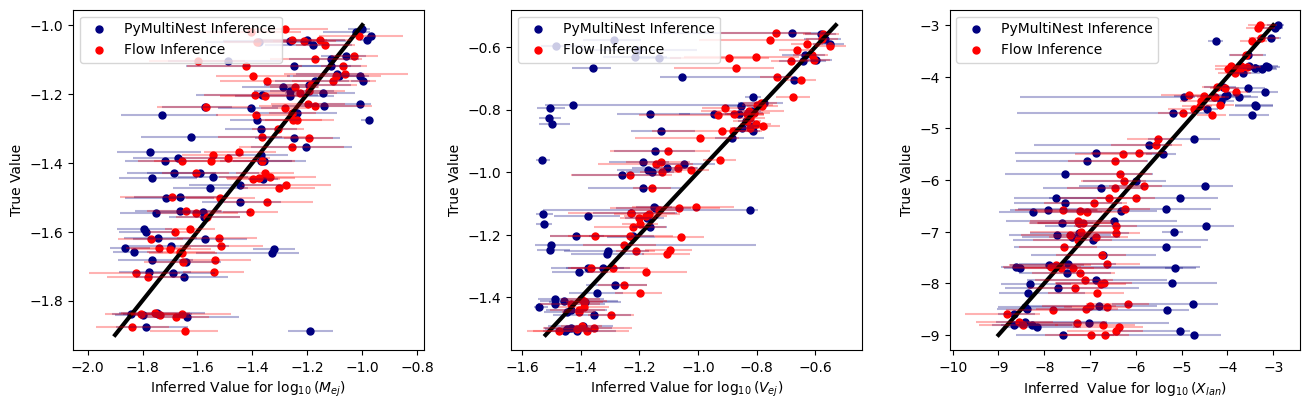

In [155]:
# both varied

fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(13,4))
fig.tight_layout()
plt.subplots_adjust(wspace=0.25)

mej_errors_mv = [mej_lower_error_list_mv, mej_upper_error_list_mv]
axs[0].scatter(mej_result_list_mv, mej_truth_list, s = 100, marker = '.', label = 'PyMultiNest Inference', color = 'navy')
axs[0].errorbar(mej_result_list_mv, mej_truth_list, xerr = mej_errors_mv, ls = 'None', ecolor = 'navy', alpha = 0.3)
mej_errors = [mej_lower_error_list, mej_upper_error_list]
axs[0].plot(np.linspace(-1.9, -1, 100), np.linspace(-1.9, -1, 100), linestyle='-', linewidth = 3, color='k')
axs[0].scatter(mej_result_list, mej_truth_list, s = 100, marker = '.', label = 'Flow Inference', color = 'r')
axs[0].errorbar(mej_result_list, mej_truth_list, xerr = mej_errors, ls = 'None', ecolor='r', alpha = 0.3)
# axs[0].axvspan(-1.9, -3, facecolor='k', alpha=0.05)
# axs[0].axvspan(-1, 0, facecolor='k', alpha=0.05)
# axs[0].set_xlim(-3, 0)
axs[0].legend(loc = 'upper left')
axs[0].set_ylabel('True Value')
axs[0].set_xlabel('Inferred Value for $\log_{{10}}(M_{{ej}})$')

vej_errors_mv = [vej_lower_error_list_mv, vej_upper_error_list_mv]
axs[1].scatter(vej_result_list_mv, vej_truth_list, s = 100, marker = '.', label = 'PyMultiNest Inference', color = 'navy')
axs[1].errorbar(vej_result_list_mv, vej_truth_list, xerr = vej_errors_mv, ls = 'None', ecolor = 'navy', alpha = 0.3)
vej_errors = [vej_lower_error_list, vej_upper_error_list]
axs[1].plot(np.linspace(-1.52, -0.53, 100), np.linspace(-1.52, -0.53, 100), linestyle='-', linewidth = 3, color='k')
axs[1].scatter(vej_result_list, vej_truth_list, s = 100, marker = '.', label = 'Flow Inference', color = 'r')
axs[1].errorbar(vej_result_list, vej_truth_list, xerr = vej_errors, ls = 'None', ecolor = 'r', alpha = 0.3)
# axs[1].axvspan(-1.53, -2.5, facecolor='k', alpha=0.05)
# axs[1].axvspan(-0.5, 0.5, facecolor='k', alpha=0.05)
# axs[1].set_xlim(-2.5, 0.5)
axs[1].legend(loc='upper left')
axs[1].set_ylabel('True Value')
axs[1].set_xlabel('Inferred Value for $\log_{{10}}(V_{{ej}})$')

xlan_errors_mv = [xlan_lower_error_list_mv, xlan_upper_error_list_mv]
axs[2].scatter(xlan_result_list_mv, xlan_truth_list, s = 100, marker = '.', label = 'PyMultiNest Inference', color = 'navy')
axs[2].errorbar(xlan_result_list_mv, xlan_truth_list, xerr = xlan_errors_mv, ls = 'None', ecolor = 'navy', alpha = 0.3)
xlan_errors = [xlan_lower_error_list, xlan_upper_error_list]
axs[2].plot(np.linspace(-9, -3, 100), np.linspace(-9, -3, 100), linestyle='-', linewidth = 3, color='k')
axs[2].scatter(xlan_result_list, xlan_truth_list, s = 100, marker = '.', label = 'Flow Inference', color = 'r')
axs[2].errorbar(xlan_result_list, xlan_truth_list, xerr = xlan_errors, ls = 'None', ecolor = 'r', alpha = 0.3)
# axs[2].axvspan(-9, -16, facecolor='k', alpha=0.05)
# axs[2].axvspan(-3, -2, facecolor='k', alpha=0.05)
# axs[2].set_xlim(-16, -2)
axs[2].legend(loc = 'upper left')
axs[2].set_ylabel('True Value')
axs[2].set_xlabel('Inferred  Value for $\log_{{10}}(X_{{lan}})$')
plt.savefig('3inf_dataprior_ptswerrors.pdf', format = 'pdf', bbox_inches = 'tight')

18:44 bilby INFO    : Key: KS-test p-value
18:44 bilby INFO    : log10_mej: 0.602026382355189
18:44 bilby INFO    : log10_vej: 0.888291190555587
18:44 bilby INFO    : log10_Xlan: 0.044984726565958984
18:44 bilby INFO    : Combined p-value: 0.28083499343423374


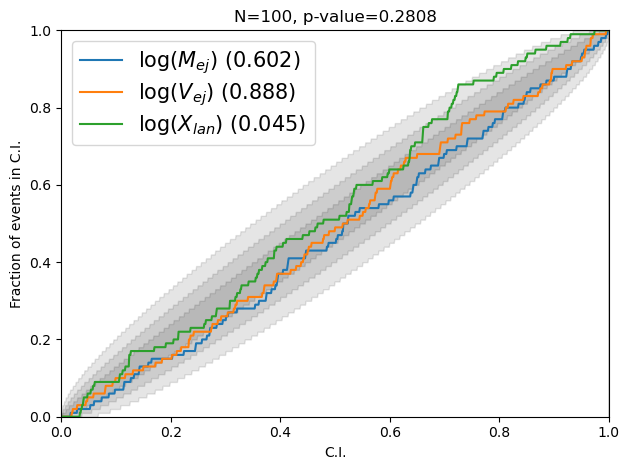

In [115]:
results = []
for i in range(0,100):
    with torch.no_grad():
        samples = flow.sample(20000, context=var_inf_dict['var_data{}'.format(i)][0].reshape((1, 3, num_points)))
    samples = samples.cpu().reshape(20000,3)
    samples[:,0].mul_(mej_max - mej_min).add_(mej_min)
    samples[:,1].mul_(vej_max - vej_min).add_(vej_min)
    samples[:,2].mul_(xlan_max - xlan_min).add_(xlan_min)
    truth = var_inf_dict['var_param{}'.format(i)].cpu()[...,0:3]
    truth = truth.squeeze(1)[0]
    results.append(cast_as_bilby_result(samples, truth, priors))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['log10_mej', 'log10_vej', 'log10_Xlan'],
                              confidence_interval = [0.68, 0.95, 0.998], legend_fontsize=15)
plt.savefig('ppplot100.pdf', format="pdf", bbox_inches="tight")

In [137]:
def get_posterior(num, inf_dict, dict_prefix, nsamples=1000):
    # get the varied result
    with torch.no_grad():
        samples = flow.sample(nsamples, context=inf_dict['{}_data{}'.format(dict_prefix, num)][0].reshape((1, 3, num_points)))
    samples = samples.cpu().reshape(nsamples,3)
    samples[:,0].mul_(mej_max - mej_min).add_(mej_min)
    samples[:,1].mul_(vej_max - vej_min).add_(vej_min)
    samples[:,2].mul_(xlan_max - xlan_min).add_(xlan_min)
    truth = inf_dict['{}_param{}'.format(dict_prefix, num)].cpu()[...,0:3]
    injections = dict.fromkeys({'log10_mej', 'log10_vej', 'log10_Xlan'})
    injections['log10_mej'] = truth.numpy()[0][0][0]
    injections['log10_vej'] = truth.numpy()[0][0][1]
    injections['log10_Xlan'] = truth.numpy()[0][0][2]
    posterior = dict.fromkeys({'log10_mej', 'log10_vej', 'log10_Xlan'})
    samples_numpy = samples.numpy()
    posterior['log10_mej'] = samples_numpy.T[0].flatten()
    posterior['log10_vej'] = samples_numpy.T[1].flatten()
    posterior['log10_Xlan'] = samples_numpy.T[2].flatten()
    posterior = pd.DataFrame(posterior)
    flow_result = bilby.result.Result(
            label="test_data",
            injection_parameters=injections,
            posterior=posterior,
            search_parameter_keys=['log10_vej', 'log10_mej', 'log10_Xlan'],
            priors=priors
        )
    return flow_result, injections

In [172]:
def comparison_plot(num, num_params, varied_dict, multinest_dict, fixed_dict = {}, fixed_available=False, plot_range=None):
    nsamples = len(multinest_dict['multinest_result{}'.format(num)].samples)

    # get the varied result
    flow_result_var, injections_var = get_posterior(num, varied_dict, 200)

    # get the fixed result
    if fixed_available == True:
        flow_result_fix, injections_fix = get_posterior(num, fixed_dict, 'fix')
        # plot the figure
        fig = bilby.result.plot_multiple(
        [flow_result_var, 
         flow_result_fix, 
         multinest_dict['multinest_result{}'.format(num)],
        ],
        labels=['Shifted Data, \nFlow with Similarity \nRep. ({} params)'.format(num_params), 
                'Fixed Data, \nFlow with Similarity \nRep. ({} params)'.format(num_params), 
                'PyMultiNest Sampling', 
               ],
        truth = injections_var,
        corner_labels = ['$\log_{{10}}(M_{{ej}})$', '$\log_{{10}}(V_{{ej}})$', '$\log_{{10}}(X_{{lan}})$'],
        colours = ['r', 'mediumseagreen', 'royalblue'],
        quantiles=(0.16, 0.84),
        titles=True,
        save=False, 
        range = plot_range
        )
        plt.show()

    else: 
        # plot the figure
        fig = bilby.result.plot_multiple(
        [flow_result_var, 
         multinest_dict['multinest_result{}'.format(num)], 
        ],
        labels=['Shifted Data, \nFlow with Similarity \nRep. ({} params)'.format(num_params), 
                'PyMultiNest Sampling', 
               ],
        truth = injections_var,
        corner_labels = ['$\log_{{10}}(M_{{ej}})$', '$\log_{{10}}(V_{{ej}})$', '$\log_{{10}}(X_{{lan}})$'],
        colours = ['r', 'royalblue'],
        quantiles=(0.16, 0.84),
        titles=True,
        save=False,
        range = plot_range
        )
        plt.show()

In [143]:
flow_result, injection = get_posterior(0, var_inf_dict, 'var')

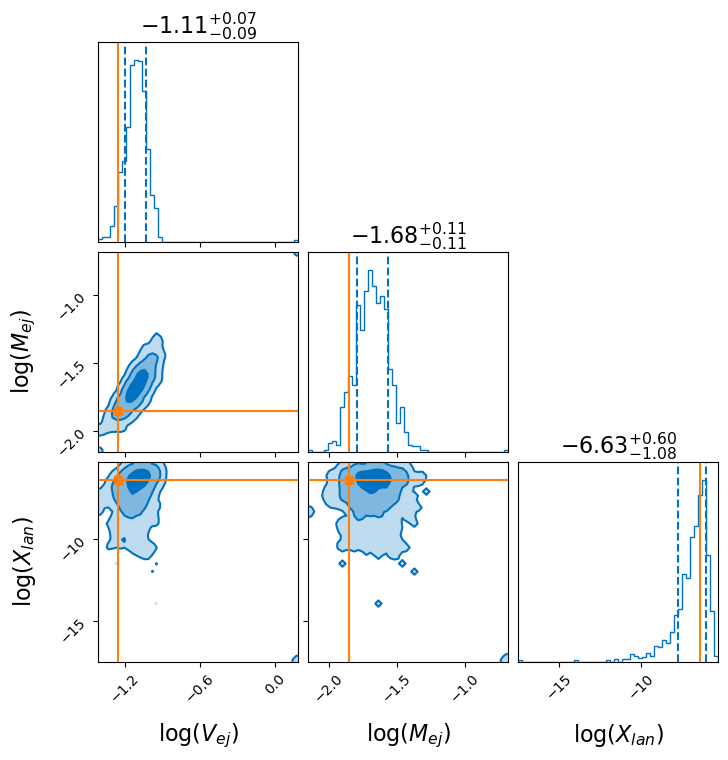

In [144]:
flow_result.plot_corner()

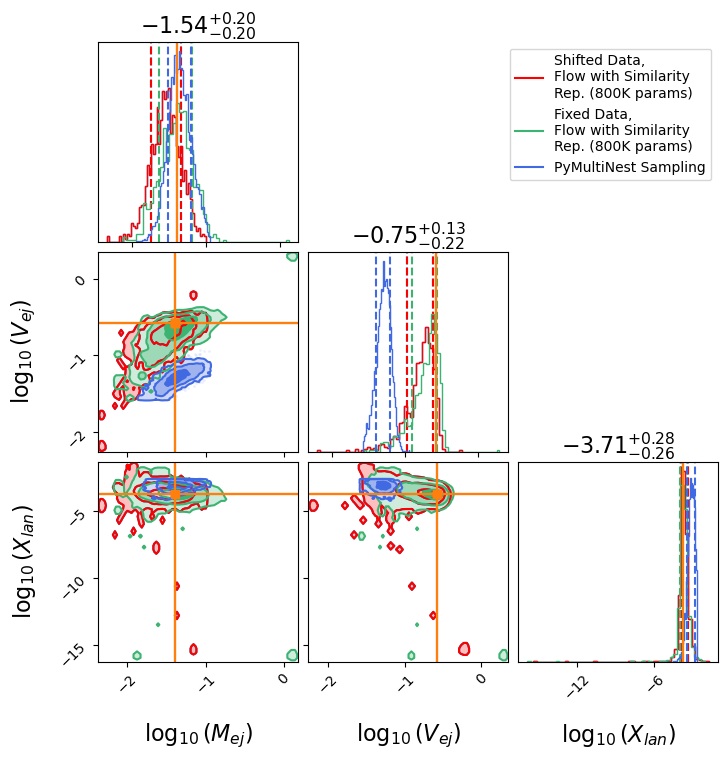

In [157]:
comparison_plot(4, '800K', var_inf_dict, multinest_dict_varied, fix_inf_dict, fixed_available=True)

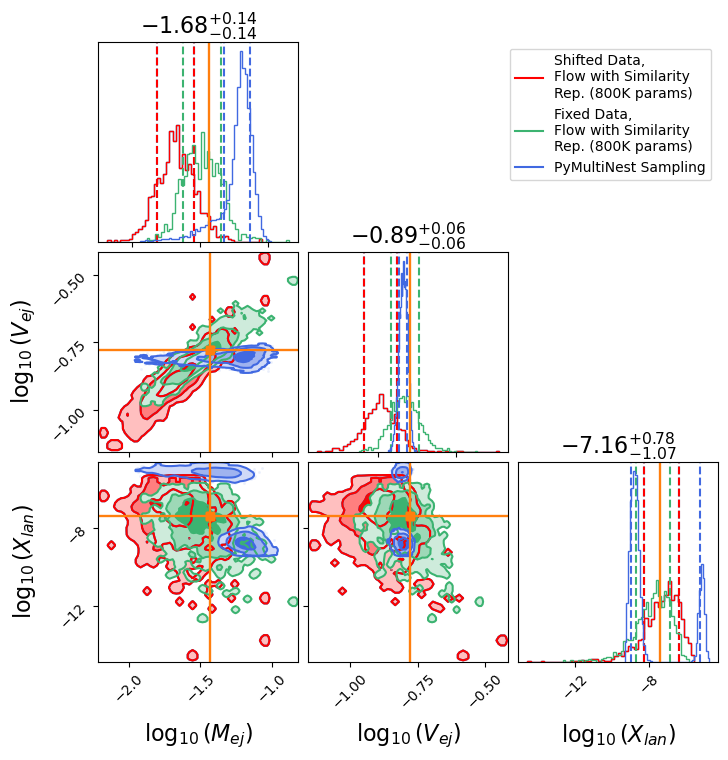

In [173]:
comparison_plot(, '800K', inf_dict_200, multinest_dict_varied, fix_inf_dict, fixed_available=True)

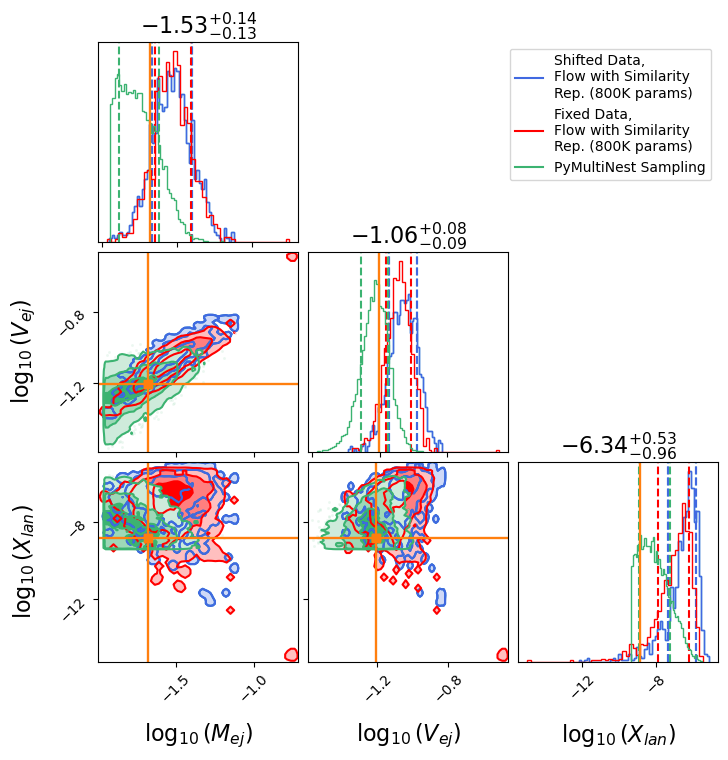

In [153]:
comparison_plot(8, '800K', var_inf_dict, multinest_dict_varied, fix_inf_dict, fixed_available=True)

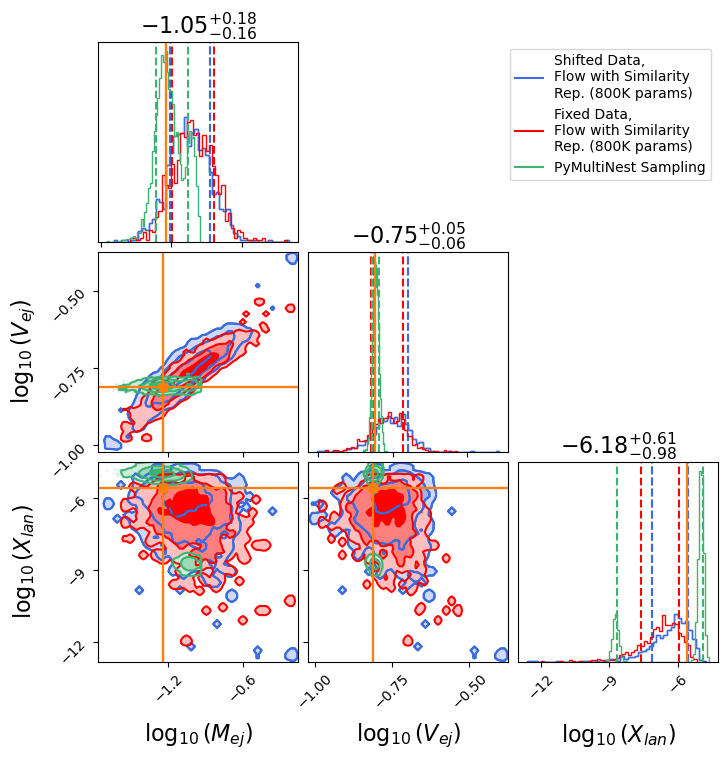

In [154]:
comparison_plot(9, '800K', var_inf_dict, multinest_dict_varied, fix_inf_dict, fixed_available=True)